# References : 

Main data pre-processing and data cleaning, comparision of randomforests with other models
### https://www.kaggle.com/code/jieyima/income-classification-model



Random forest training, confusion matrix, ROC curves, visualization, feature importance etc
### https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb


### https://nthu-datalab.github.io/ml/labs/03_Decision-Tree_Random-Forest/03_Decision-Tree_Random-Forest.html


### Step 1 : Import necessary libraries

In [1]:
from tqdm import tqdm
import psutil
import time
import math
import os
from subprocess import call

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
%matplotlib inline
from IPython.display import Image, SVG, HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree


#import warnings
#import kagglehub
#from sklearn.linear_model import Perceptron
#from sklearn.svm import SVC
### cross validation

#from sklearn.model_selection import cross_val_predict #prediction
#from sklearn.cluster import KMeans

#from sklearn.metrics import silhouette_samples
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import accuracy_score

#from sklearn.decomposition import PCA
#from pandas.tools.plotting import scatter_matrix
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.model_selection import GridSearchCV

#importing all the required ML packages
#from sklearn import metrics #accuracy measure
RSEED = 100

### Step 2: Data Cleaning functions

The reference code contained lot of individual blocks, I condensed them all into one single function

In [2]:
#This function cleans data before EDA
def clean_data(df):
    df = df.copy() 
    df.age = df.age.astype(float)
    df['hours-per-week'] = df['hours-per-week'].astype(float)
    df = df.dropna()
    df['predclass'] = df['income']
    df = df.drop(columns=['income'])
    df['education-num'] = df['educational-num']
    df = df.drop(columns=['educational-num'])
    
    education_replacements = {
        'Preschool': 'dropout', '10th': 'dropout', '11th': 'dropout', '12th': 'dropout',
        '1st-4th': 'dropout', '5th-6th': 'dropout', '7th-8th': 'dropout', '9th': 'dropout',
        'HS-Grad': 'HighGrad', 'HS-grad': 'HighGrad',
        'Some-college': 'CommunityCollege', 'Assoc-acdm': 'CommunityCollege', 'Assoc-voc': 'CommunityCollege',
        'Bachelors': 'Bachelors',
        'Masters': 'Masters', 'Prof-school': 'Masters',
        'Doctorate': 'Doctorate'
    }
    df['education'] = df['education'].replace(education_replacements)
    
    marital_status_replacements = {
        'Never-married': 'NotMarried',
        'Married-AF-spouse': 'Married', 'Married-civ-spouse': 'Married',
        'Married-spouse-absent': 'NotMarried',
        'Separated': 'Separated', 'Divorced': 'Separated',
        'Widowed': 'Widowed'
    }
    df['marital-status'] = df['marital-status'].replace(marital_status_replacements)
    
    return df

# This function prepares data after EDA
# https://stackoverflow.com/questions/35576509/making-a-jupyter-notebook-output-cell-fullscreen
def prepare_data(df, sample_size=15000):
    # URL for the dataset
    #dataset_url = "https://archive.ics.uci.edu/ml/datasets/Adult"
    dataset_url = "https://www.kaggle.com/datasets/wenruliu/adult-income-dataset?resource=download"
    
    # Attributes and value ranges (obtained from commented out UCI link)
    attributes_info = {
        'age': 'continuous',
        'workclass': 'Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked',
        'fnlwgt': 'continuous',
        'education': 'Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool',
        'education-num': 'continuous',
        'marital-status': 'Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse',
        'occupation': 'Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces',
        'relationship': 'Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried',
        'race': 'White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black',
        'sex': 'Female, Male',
        'capital-gain': 'continuous',
        'capital-loss': 'continuous',
        'hours-per-week': 'continuous',
        'native-country': 'United-States, Cambodia, England, Puerto-Rico, Canada, Germany, ...',
        'income': '<=50K, >50K'
    }
    
    # Note: I am limiting the data to get low accuracies + faster training times
    df = df.sample(n=sample_size, random_state=RSEED)
    
    # Print dataset information before label encoding and scaling
    print("Dataset URL:", dataset_url)
    print("\nAttributes and Value Ranges:")
    for attr, val_range in attributes_info.items():
        print(f"{attr}: {val_range}")
    
    # Split the data into training and testing sets before encoding and scaling
    X = df.drop('predclass', axis=1)
    y = df['predclass']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)
    
    # Select 10 training and 10 test examples before label encoding and scaling
    sample_train = X_train.sample(n=10, random_state=RSEED)
    sample_test = X_test.sample(n=10, random_state=RSEED)
    
    sample_train['predclass'] = y_train.loc[sample_train.index].values
    sample_test['predclass'] = y_test.loc[sample_test.index].values
    
    print("\nSample Training Examples (Before Label Encoding and Scaling):")
    display(HTML(sample_train.to_html()))
    
    print("\nSample Testing Examples (Before Label Encoding and Scaling):")
    display(HTML(sample_test.to_html()))
    
    # Apply Label Encoding to the entire dataset
    df_encoded = df.apply(LabelEncoder().fit_transform)
    
    # Drop specified columns --> redundant as we performed feature engineering in clean_data function
    drop_elements = ['education', 'native-country', 'predclass', 'age_bin', 'age-hours_bin', 'hours-per-week_bin']
    y_encoded = df_encoded["predclass"]
    X_encoded = df_encoded.drop(drop_elements, axis=1)
    
    # Split the data into training and testing sets after encoding
    X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=RSEED)
    
    # Scale the entire training and testing data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    X_test_scaled = scaler.transform(X_test_encoded)
    
    # Apply Label Encoding to the stored 10 training and 10 test examples
    sample_train_encoded = sample_train.apply(LabelEncoder().fit_transform)
    sample_test_encoded = sample_test.apply(LabelEncoder().fit_transform)
    
    # Drop specified columns for the stored examples
    sample_train_encoded = sample_train_encoded.drop(drop_elements, axis=1)
    sample_test_encoded = sample_test_encoded.drop(drop_elements, axis=1)
    
    # Scale the stored 10 training and 10 test examples
    sample_train_encoded_scaled = scaler.transform(sample_train_encoded)
    sample_test_encoded_scaled = scaler.transform(sample_test_encoded)
    
    sample_train_encoded_scaled_df = pd.DataFrame(sample_train_encoded_scaled, columns=X_encoded.columns)
    sample_test_encoded_scaled_df = pd.DataFrame(sample_test_encoded_scaled, columns=X_encoded.columns)
    
    sample_train_encoded_scaled_df['predclass'] = y_train.loc[sample_train.index].values
    sample_test_encoded_scaled_df['predclass'] = y_test.loc[sample_test.index].values
    
    print("\nSample Training Examples (After Label Encoding and Scaling):")
    display(HTML(sample_train_encoded_scaled_df.to_html()))
    
    print("\nSample Testing Examples (After Label Encoding and Scaling):")
    display(HTML(sample_test_encoded_scaled_df.to_html()))
    
    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, X_encoded.columns





### Step 3: Exploratory Data Analysis Function

The reference code contained lot of individual blocks, I condensed them all into one single function

In [3]:
def perform_eda(df):
    print(df.info())
    print(df.isnull().sum())
    
    categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'predclass']
    for col in categorical_columns:
        print(f'{col}: {df[col].unique()}')
    
    plt.figure(figsize=(20, 1))
    sns.countplot(y="predclass", data=df, hue="predclass", palette="rainbow", legend=False)
    plt.title('Count of Predclass')
    plt.show()
    
    plt.figure(figsize=(20, 3))
    sns.countplot(y="education", data=df, hue="education", palette="rainbow", legend=False)
    plt.title('Count of Education Levels')
    plt.show()
    
    plt.figure(figsize=(20, 2))
    sns.countplot(y="marital-status", data=df, hue="marital-status", palette="rainbow", legend=False)
    plt.title('Count of Marital Status')
    plt.show()
    
    plt.figure(figsize=(20, 3))
    sns.countplot(y="workclass", data=df, hue="workclass", palette="rainbow", legend=False)
    plt.title('Count of Workclass')
    plt.show()
    
    df['age_bin'] = pd.cut(df['age'], 20)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(y="age_bin", data=df, hue="age_bin", palette="rainbow", legend=False)
    plt.title('Count of Age Bins')
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['predclass'] == '>50K']['age'], kde=True, label=">$50K", color="blue")
    sns.histplot(df[df['predclass'] == '<=50K']['age'], kde=True, label="<=$50K", color="red")
    plt.title('Age Distribution by Predclass')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20, 5))
    sns.countplot(x="race", hue="gender", data=df, palette="rainbow")
    plt.title('Count of Race by Gender')
    plt.show()
    
    df['hours-per-week_bin'] = pd.cut(df['hours-per-week'], 10)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(y="hours-per-week_bin", data=df, hue="hours-per-week_bin", palette="rainbow", legend=False)
    plt.title('Count of Hours-per-Week Bins')
    plt.subplot(1, 2, 2)
    sns.histplot(df['hours-per-week'], kde=True, color="green")
    sns.histplot(df[df['predclass'] == '>50K']['hours-per-week'], kde=True, label=">$50K", color="blue")
    sns.histplot(df[df['predclass'] == '<=50K']['hours-per-week'], kde=True, label="<$50K", color="red")
    plt.title('Hours-per-Week Distribution by Predclass')
    plt.legend()
    plt.show()
    
    df['age-hours'] = df['age'] * df['hours-per-week']
    df['age-hours_bin'] = pd.cut(df['age-hours'], 10)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(y="age-hours_bin", data=df, hue="age-hours_bin", palette="rainbow", legend=False)
    plt.title('Count of Age-Hours Bins')
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['predclass'] == '>50K']['age-hours'], kde=True, label=">$50K", color="blue")
    sns.histplot(df[df['predclass'] == '<=50K']['age-hours'], kde=True, label="<$50K", color="red")
    plt.title('Age-Hours Distribution by Predclass')
    plt.legend()
    plt.show()
    
    sns.pairplot(df, hue='predclass', palette='deep', height=3, diag_kind='kde', diag_kws=dict(fill=True), plot_kws=dict(s=20)).set(xticklabels=[])
    plt.title('Pairplot of Features by Predclass')
    plt.show()
    


### Step 4: Comparision of Various ML Models (for chosen dataset)

Note: This is not required in the assignment, but I did it anyway as it was in reference code. Gives good insights on random forest performance

Note: I modularized the code in reference code into a single function for better readability

In [4]:
def measure_performance(X_train, y_train, X_test, y_test):
    start_time = time.time()
    process = psutil.Process()
    initial_memory = process.memory_info().rss
    
    kfold = KFold(n_splits=10, random_state=RSEED, shuffle=True)
    classifiers = ['Naive Bayes', 'Linear SVM', 'Radial SVM', 'Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest']
    models = [GaussianNB(), svm.SVC(kernel='linear'), svm.SVC(kernel='rbf', C=1, gamma=0.22), LogisticRegression(), DecisionTreeClassifier(),
              KNeighborsClassifier(n_neighbors=9), RandomForestClassifier(n_estimators=25)]
    
    xyz = []
    accuracy = []
    std = []
    training_times = []
    testing_times = []
    training_scores = []
    testing_scores = []
    
    for i, model in enumerate(tqdm(models, desc="Model Training and Testing Progress")):
        print(f"Training and testing {classifiers[i]}...")
        
        # Measure training time
        train_start_time = time.time()
        model.fit(X_train, y_train)
        train_end_time = time.time()
        training_time = train_end_time - train_start_time
        training_times.append(training_time)
        
        # Measure training accuracy
        train_score = model.score(X_train, y_train)
        training_scores.append(train_score)
        
        # Measure cross-validation accuracy
        cv_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
        xyz.append(cv_result.mean())
        std.append(cv_result.std())
        accuracy.append(cv_result)
        
        # Measure testing time
        test_start_time = time.time()
        test_score = model.score(X_test, y_test)
        test_end_time = time.time()
        testing_time = test_end_time - test_start_time
        testing_times.append(testing_time)
        
        # Measure testing accuracy
        testing_scores.append(test_score)
    
    models_dataframe = pd.DataFrame({
        'CV Mean': xyz,
        'Std': std,
        'Training Time (s)': training_times,
        'Testing Time (s)': testing_times,
        'Training Accuracy': training_scores,
        'Test Accuracy': testing_scores
    }, index=classifiers)
    
    end_time = time.time()
    final_memory = process.memory_info().rss
    
    execution_time = end_time - start_time
    memory_consumed = (final_memory - initial_memory) / (1024 * 1024) 
    
    print(f"Total Execution Time: {execution_time:.2f} seconds")
    print(f"Total Memory Consumed: {memory_consumed:.2f} MB")
    
    return models_dataframe, execution_time, memory_consumed, models

In [5]:
def compare_ML_models_graphs(models_dataframe, total_execution_time, total_memory_consumed):
    # Plot Training Time
    plt.figure(figsize=(12, 6))
    models_dataframe['Training Time (s)'].plot(kind='bar', color='skyblue')
    plt.title('Training Time for Each Model')
    plt.ylabel('Training Time (seconds)')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot Testing Time
    plt.figure(figsize=(12, 6))
    models_dataframe['Testing Time (s)'].plot(kind='bar', color='lightgreen')
    plt.title('Testing Time for Each Model')
    plt.ylabel('Testing Time (seconds)')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot Training Accuracy
    plt.figure(figsize=(12, 6))
    models_dataframe['Training Accuracy'].plot(kind='bar', color='salmon')
    plt.title('Training Accuracy for Each Model')
    plt.ylabel('Training Accuracy')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot Test Accuracy
    plt.figure(figsize=(12, 6))
    models_dataframe['Test Accuracy'].plot(kind='bar', color='orange')
    plt.title('Test Accuracy for Each Model')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot Cross-Validation Mean Accuracy
    plt.figure(figsize=(12, 6))
    models_dataframe['CV Mean'].plot(kind='bar', color='purple')
    plt.title('Cross-Validation Mean Accuracy for Each Model')
    plt.ylabel('CV Mean Accuracy')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()
    
    # Print total execution time and memory consumed
    print(f"Total Execution Time: {total_execution_time:.2f} seconds")
    print(f"Total Memory Consumed: {total_memory_consumed:.2f} MB")

### Step 5: Auxillary functions for Random Forest Testing (for various tasks such as visualization, training and testing)

Note: I took code from reference codes and modularized them into functions

In [6]:
# Performs training and evaluation
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time
    
    start_test_time = time.time()
    y_pred = model.predict(X_test)
    end_test_time = time.time()
    test_time = end_test_time - start_test_time
    
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    return model, y_pred, accuracy, cm, train_time, test_time, classification_rep

# Plots single confusion matrix --> Not printed in notebook, but used
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# I wrote this function for joining confusion matrices for better comparison 
def plot_all_confusion_matrices(confusion_matrices, model_names):
    num_plots = len(confusion_matrices)
    for i in range(0, num_plots, 4):
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        axes = axes.flatten()
        for ax, cm, model_name in zip(axes, confusion_matrices[i:i+4], model_names[i:i+4]):
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'], ax=ax)
            ax.set_title(f"Confusion Matrix: {model_name}")
            ax.set_ylabel('Actual')
            ax.set_xlabel('Predicted')
        plt.tight_layout()
        plt.show()

# Plots the ROC curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='best')
    plt.show()

# This function stores the tree image in a directory inside present working directory
# Note: This only stores tree with limited depth for easy visualization purposes

def visualize_tree(tree, feature_names, filename, max_depth=None):
    if not os.path.exists("./output/"):
        os.mkdir("./output/")
    
    # Export the tree to a DOT file with max_depth
    export_graphviz(
        tree, out_file=f'./output/{filename}.dot', 
        feature_names=feature_names, filled=True, rounded=True,
        special_characters=True, max_depth=max_depth  # Limit the depth of the tree for visualization
    )
    
    with open(f'./output/{filename}.dot') as f:
        dot_graph = f.read()
    graph = graphviz.Source(dot_graph)
    graph.format = 'svg'
    graph.render(filename=f'./output/{filename}', format='svg')
    
    # Returning the image path for --> Displaying the tree in the Jupyter notebook
    return SVG(filename=f'./output/{filename}.svg')



# This function helps us to compare different models on which feature is given more importance
def print_feature_importance(models, feature_names):
    feature_importances = {}
    for model_name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            fi = pd.DataFrame({'feature': feature_names,
                               'importance': model.feature_importances_}).\
                                sort_values('importance', ascending=False)
            feature_importances[model_name] = fi
            print(f"\nFeature Importance for {model_name}:")
            print(fi.head())
    return feature_importances

# I wrote this function for joining feature importance plots for better comparison 
def plot_all_feature_importances(feature_importances):
    num_plots = len(feature_importances)
    model_names = list(feature_importances.keys())
    for i in range(0, num_plots, 4):
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        axes = axes.flatten()
        for ax, model_name in zip(axes, model_names[i:i+4]):
            fi = feature_importances[model_name]
            sns.barplot(x='importance', y='feature', data=fi, ax=ax)
            ax.set_title(f'Feature Importance: {model_name}')
        plt.tight_layout()
        plt.show()

# Printing hyper-params as assignment asks us to
def print_hyperparameters(models):
    hyperparameters = {}
    for model_name, model in models.items():
        hyperparameters[model_name] = model.get_params()
        print(f"\nHyper-parameters for {model_name}:")
        print(model.get_params())
    return hyperparameters

# Based on accuracy, I am printing top-10 trees, bottom-10 trees
# I am also printing first 10 and last 10 trees
def evaluate_top_bottom_trees(random_forest, X_test, y_test):
    tree_accuracies = []
    for i, estimator in enumerate(random_forest.estimators_):
        y_pred = estimator.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        tree_accuracies.append((i, accuracy, estimator))
    
    # Capture the first 10 and last 10 trees before sorting
    first_10_trees = tree_accuracies[:10]
    last_10_trees = tree_accuracies[-10:]
    
    # Sort the trees based on accuracy
    tree_accuracies.sort(key=lambda x: x[1], reverse=True)
    top_10_trees = tree_accuracies[:10]
    bottom_10_trees = tree_accuracies[-10:]
    
    top_10_df = pd.DataFrame(top_10_trees, columns=['Tree Index', 'Accuracy', 'Estimator'])
    bottom_10_df = pd.DataFrame(bottom_10_trees, columns=['Tree Index', 'Accuracy', 'Estimator'])
    first_10_df = pd.DataFrame(first_10_trees, columns=['Tree Index', 'Accuracy', 'Estimator'])
    last_10_df = pd.DataFrame(last_10_trees, columns=['Tree Index', 'Accuracy', 'Estimator'])

    return {
        "top_10_trees": top_10_df,
        "bottom_10_trees": bottom_10_df,
        "first_10_trees": first_10_df,
        "last_10_trees": last_10_df
    }

# Wrapper function for training etc (For cleaner code)
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations=None):
    model, y_pred, accuracy, cm, train_time, test_time, classification_rep = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    models[model_name] = model
    confusion_matrices.append(cm)
    accuracies.append(accuracy)
    classification_reports[model_name] = classification_rep
    if isinstance(model, RandomForestClassifier):
        tree_images[model_name] = visualize_tree(model.estimators_[0], feature_names, model_name.replace(" ", "_").lower(), max_depth=2)
        if tree_evaluations is not None:
            tree_evaluations[model_name] = evaluate_top_bottom_trees(model, X_test, y_test)
    else:
        tree_images[model_name] = visualize_tree(model, feature_names, model_name.replace(" ", "_").lower(), max_depth=2)
    return train_time, test_time


### Step 6: Main decision tree and random forest comparison function

Note: I modularized the function for cleaner readability. This will train the models, evaluate and plot the statistics.

This will compare the following models

1. 'Decision Tree (CART)' 
2. 'Decision Tree (Entropy)' 
3. 'Random Forest (5 trees)'
4. 'Random Forest (10 trees)'
5. 'Random Forest (25 trees)'
6. 'Random Forest (50 trees)'
7. 'Random Forest (75 trees)'
8. 'Random Forest (100 trees)'




In [7]:
def compare_decision_tree_vs_random_forest(X_train, y_train, X_test, y_test, feature_names):
    models = {}
    confusion_matrices = []
    accuracies = []
    tree_images = {}
    train_times = []
    test_times = []
    classification_reports = {}
    tree_evaluations = {}
    
    # Train and evaluate Decision Tree with CART (default)
    train_time, test_time = train_and_evaluate(DecisionTreeClassifier(random_state=RSEED), "Decision Tree (CART)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Decision Tree with entropy criterion (Approximate C4.5 but not true C4.5)
    train_time, test_time = train_and_evaluate(DecisionTreeClassifier(criterion='entropy', random_state=RSEED), "Decision Tree (Entropy)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Random Forest with 5 trees
    train_time, test_time = train_and_evaluate(RandomForestClassifier(n_estimators=5, random_state=RSEED), "Random Forest (5 trees)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Random Forest with 10 trees
    train_time, test_time = train_and_evaluate(RandomForestClassifier(n_estimators=10, random_state=RSEED), "Random Forest (10 trees)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Random Forest with 25 trees
    train_time, test_time = train_and_evaluate(RandomForestClassifier(n_estimators=25, random_state=RSEED), "Random Forest (25 trees)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Random Forest with 50 trees
    train_time, test_time = train_and_evaluate(RandomForestClassifier(n_estimators=50, random_state=RSEED), "Random Forest (50 trees)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Random Forest with 75 trees
    train_time, test_time = train_and_evaluate(RandomForestClassifier(n_estimators=75, random_state=RSEED), "Random Forest (75 trees)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Train and evaluate Random Forest with 100 trees
    train_time, test_time = train_and_evaluate(RandomForestClassifier(n_estimators=100, random_state=RSEED), "Random Forest (100 trees)", X_train, y_train, X_test, y_test, feature_names, models, confusion_matrices, accuracies, tree_images, classification_reports, tree_evaluations)
    train_times.append(train_time)
    test_times.append(test_time)
    
    # Plot accuracies
    model_names = ['Decision Tree (CART)', 'Decision Tree (Entropy)', 'Random Forest (5 trees)', 'Random Forest (10 trees)', 'Random Forest (25 trees)', 'Random Forest (50 trees)', 'Random Forest (75 trees)', 'Random Forest (100 trees)']
    
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
    plt.title('Model Comparison: Decision Tree (CART) vs Decision Tree (Entropy) vs Random Forest')
    plt.ylabel('Accuracy')
    plt.xlabel('Models')
    plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)  #Note: I am shifting y axis for better readability
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot ROC curves for all models
    plot_roc_curves(models, X_test, y_test)
    
    # Print feature importance for all models
    feature_importances = print_feature_importance(models, feature_names)
    
    # Plot all feature importances together
    plot_all_feature_importances(feature_importances)
    
    # Print hyper-parameters for all models
    hyperparameters = print_hyperparameters(models)
    
    # Plot all confusion matrices together
    plot_all_confusion_matrices(confusion_matrices, model_names)
    
    # Print classification reports 
    print("\nClassification Reports:")
    for model_name, report in classification_reports.items():
        print(f"\nClassification Report for {model_name}:")
        display(pd.DataFrame(report).transpose())
    
    # Tabulate training and testing times
    time_df = pd.DataFrame({
        'Model': model_names,
        'Training Time (s)': train_times,
        'Testing Time (s)': test_times
    })
    print("\nTraining and Testing Times:")
    display(time_df)
    
    # Plot training and testing times
    time_df.plot(x='Model', kind='bar', figsize=(10, 6))
    plt.title('Training and Testing Times')
    plt.ylabel('Time (s)')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot top 10, bottom 10 trees etc...
    for model_name, evaluations in tree_evaluations.items():
        combined_df = pd.DataFrame({
            'Top 10 Trees Index': evaluations['top_10_trees']['Tree Index'].tolist(),
            'Top 10 Trees Accuracy': evaluations['top_10_trees']['Accuracy'].tolist(),
            'Bottom 10 Trees Index': evaluations['bottom_10_trees']['Tree Index'].tolist(),
            'Bottom 10 Trees Accuracy': evaluations['bottom_10_trees']['Accuracy'].tolist(),
            'First 10 Trees Index': evaluations['first_10_trees']['Tree Index'].tolist(),
            'First 10 Trees Accuracy': evaluations['first_10_trees']['Accuracy'].tolist(),
            'Last 10 Trees Index': evaluations['last_10_trees']['Tree Index'].tolist(),
            'Last 10 Trees Accuracy': evaluations['last_10_trees']['Accuracy'].tolist()
        })
        print(f"\nTop and Bottom Trees for {model_name}:")
        display(combined_df)
    
    results = {
        "models": models,
        "accuracies": accuracies,
        "confusion_matrices": confusion_matrices,
        "feature_importances": feature_importances,
        "hyperparameters": hyperparameters,
        "classification_reports": classification_reports,
        "tree_images": tree_images,
        "train_times": train_times,
        "test_times": test_times
    }
    
    return results

# ACTUAL CODE EXECUTION STARTS NOW

### Step 7: Read the data and clean it

Note: Data contains some redundant features etc

In [8]:
income_df = pd.read_csv("./datasets/income/adult.csv")
income_df.head()

age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

In [9]:
income_df.describe()

age        fnlwgt  educational-num  capital-gain  \
count  48842.000000  4.884200e+04     48842.000000  48842.000000   
mean      38.643585  1.896641e+05        10.078089   1079.067626   
std       13.710510  1.056040e+05         2.570973   7452.019058   
min       17.000000  1.228500e+04         1.000000      0.000000   
25%       28.000000  1.175505e+05         9.000000      0.000000   
50%       37.000000  1.781445e+05        10.000000      0.000000   
75%       48.000000  2.376420e+05        12.000000      0.000000   
max       90.000000  1.490400e+06        16.000000  99999.000000   

       capital-loss  hours-per-week  
count  48842.000000    48842.000000  
mean      87.502314       40.422382  
std      403.004552       12.391444  
min        0.000000        1.000000  
25%        0.000000       40.000000  
50%        0.000000       40.000000  
75%        0.000000       45.000000  
max     4356.000000       99.000000

In [10]:
cleaned_df = clean_data(income_df)

### Step 8: Perform Exploratory Data Analysis and Train:Test Split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  float64
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  int64  
 3   education       48842 non-null  object 
 4   marital-status  48842 non-null  object 
 5   occupation      48842 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   gender          48842 non-null  object 
 9   capital-gain    48842 non-null  int64  
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  48842 non-null  float64
 12  native-country  48842 non-null  object 
 13  predclass       48842 non-null  object 
 14  education-num   48842 non-null  int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 5.6+ MB
None
age               0
workclass         0
fnlwgt            0

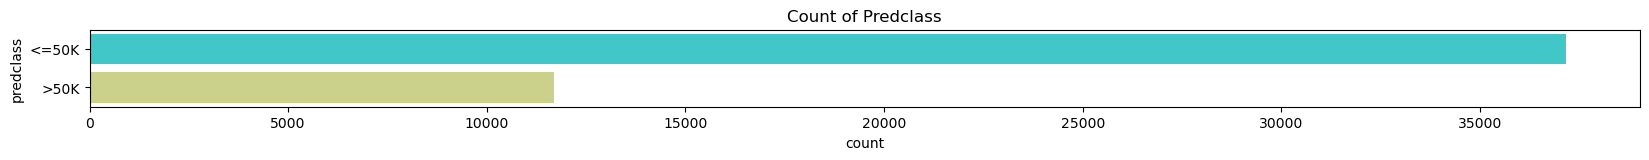

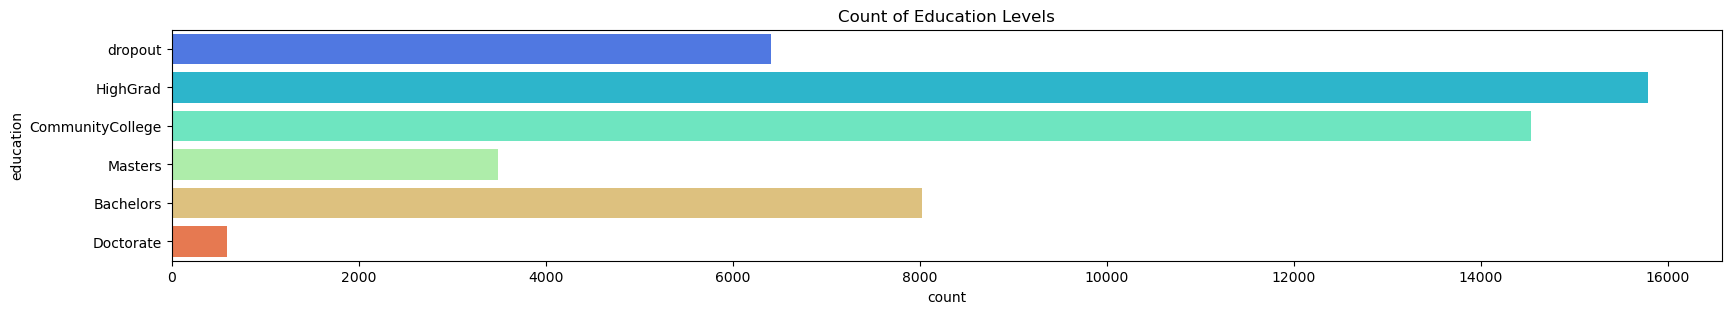

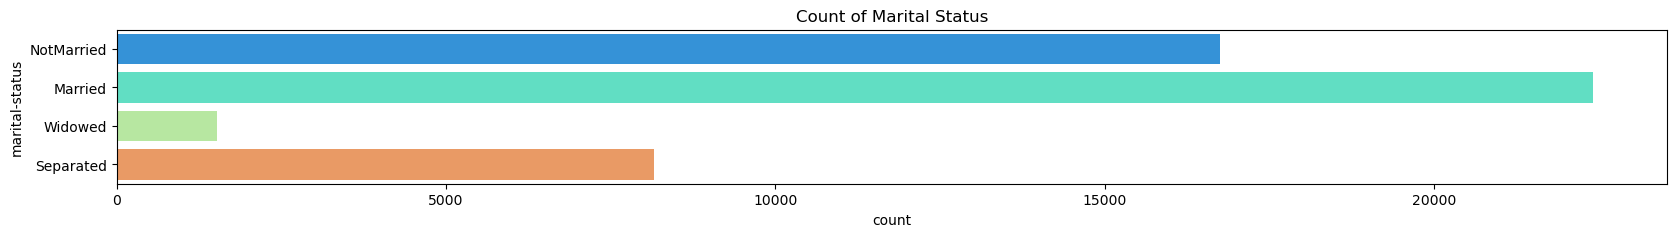

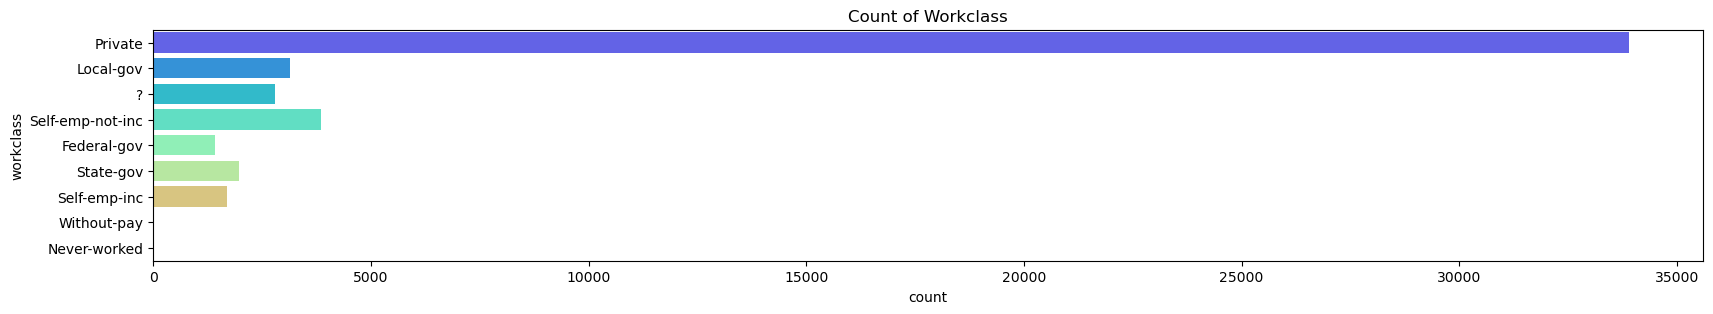

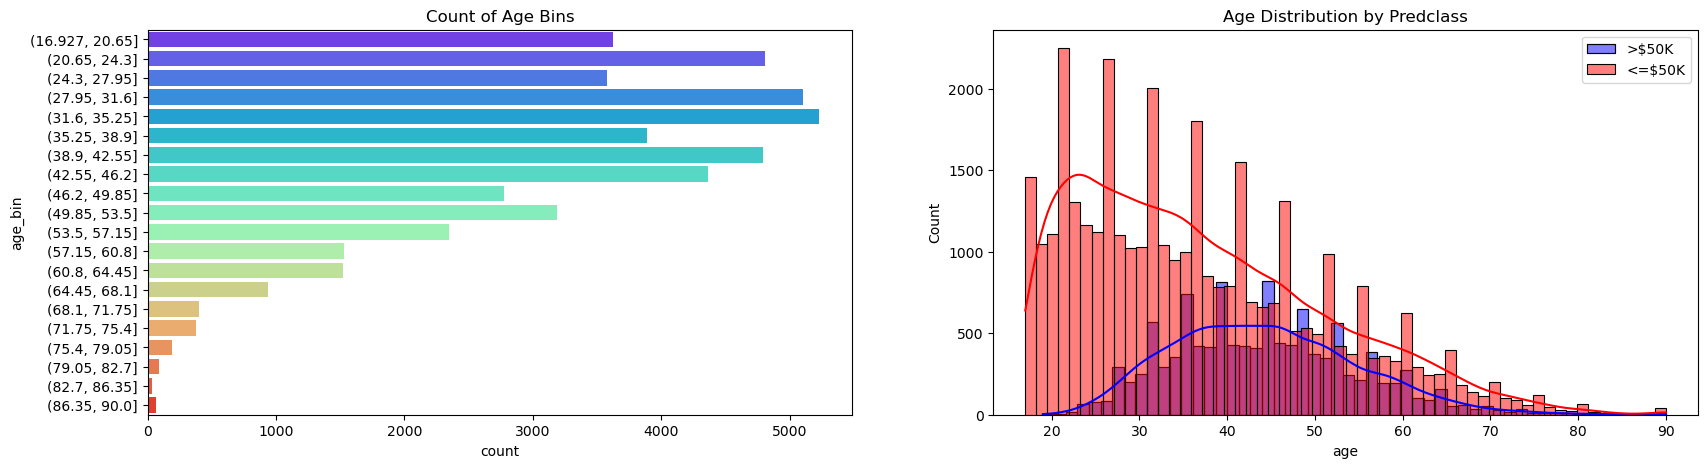

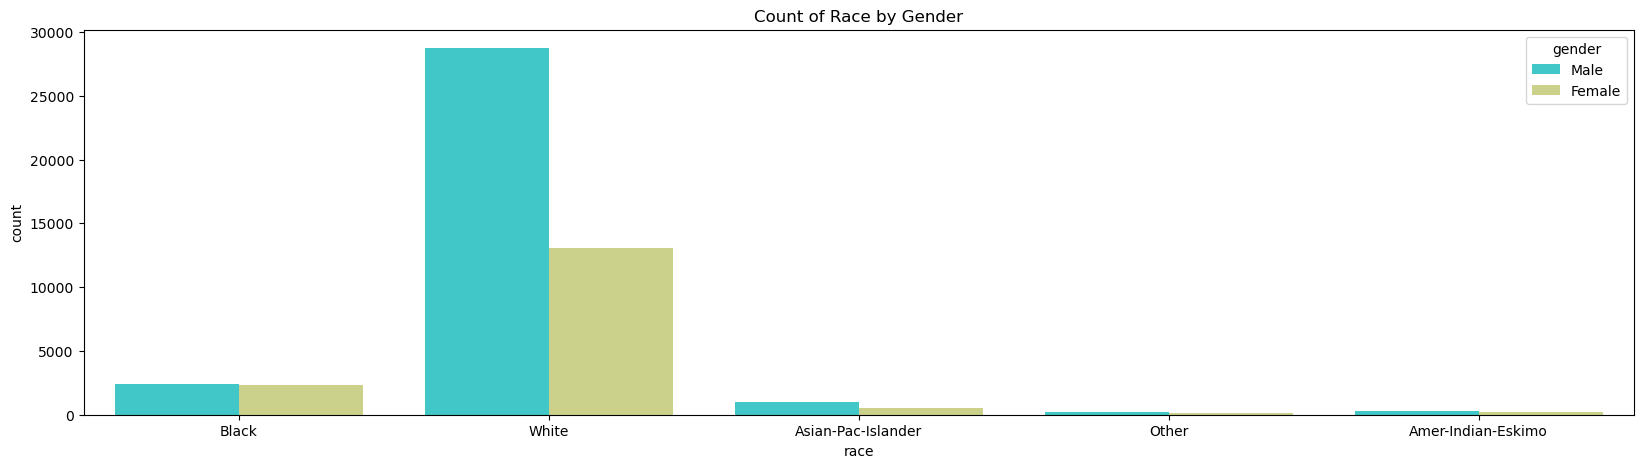

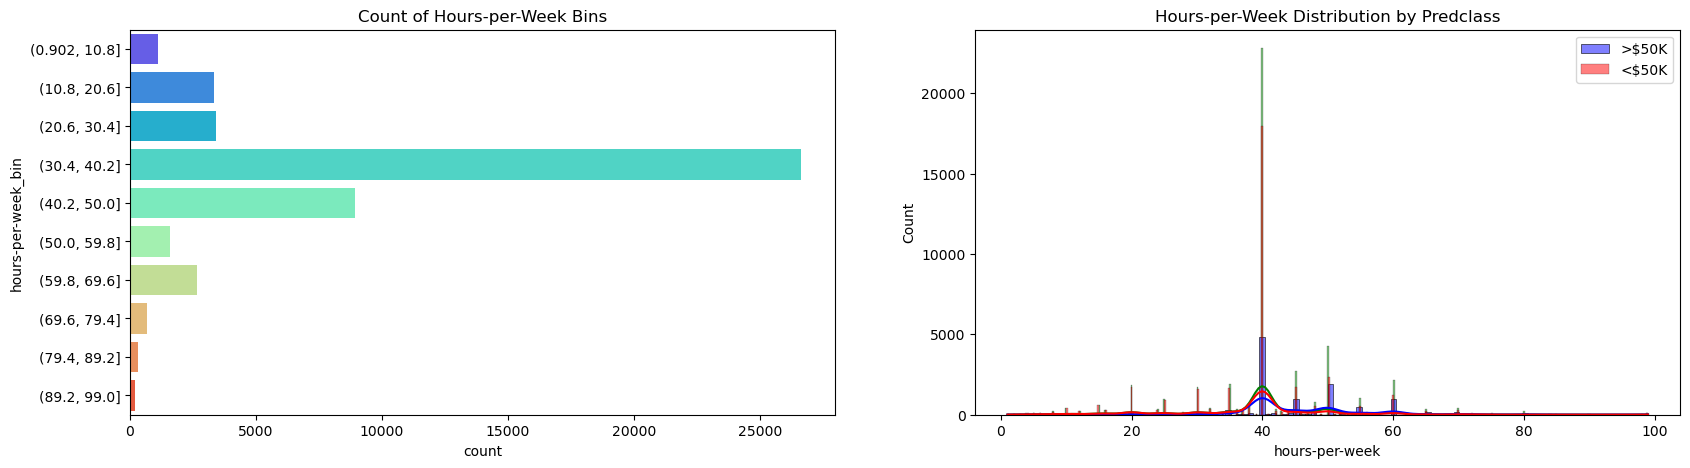

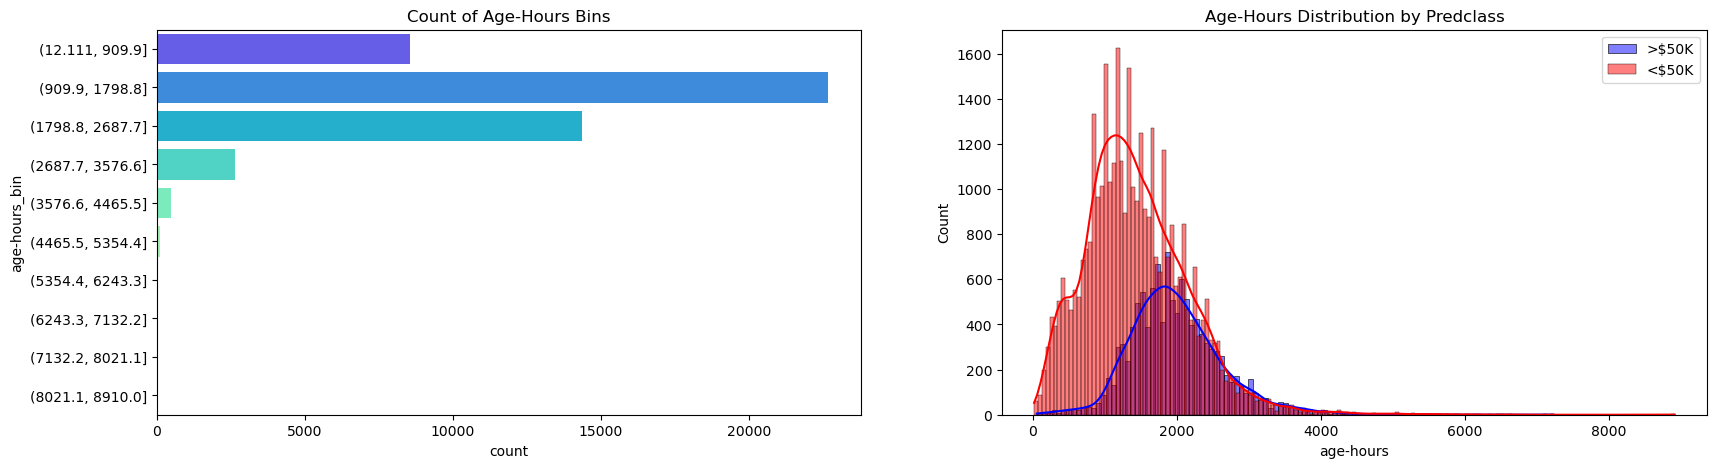

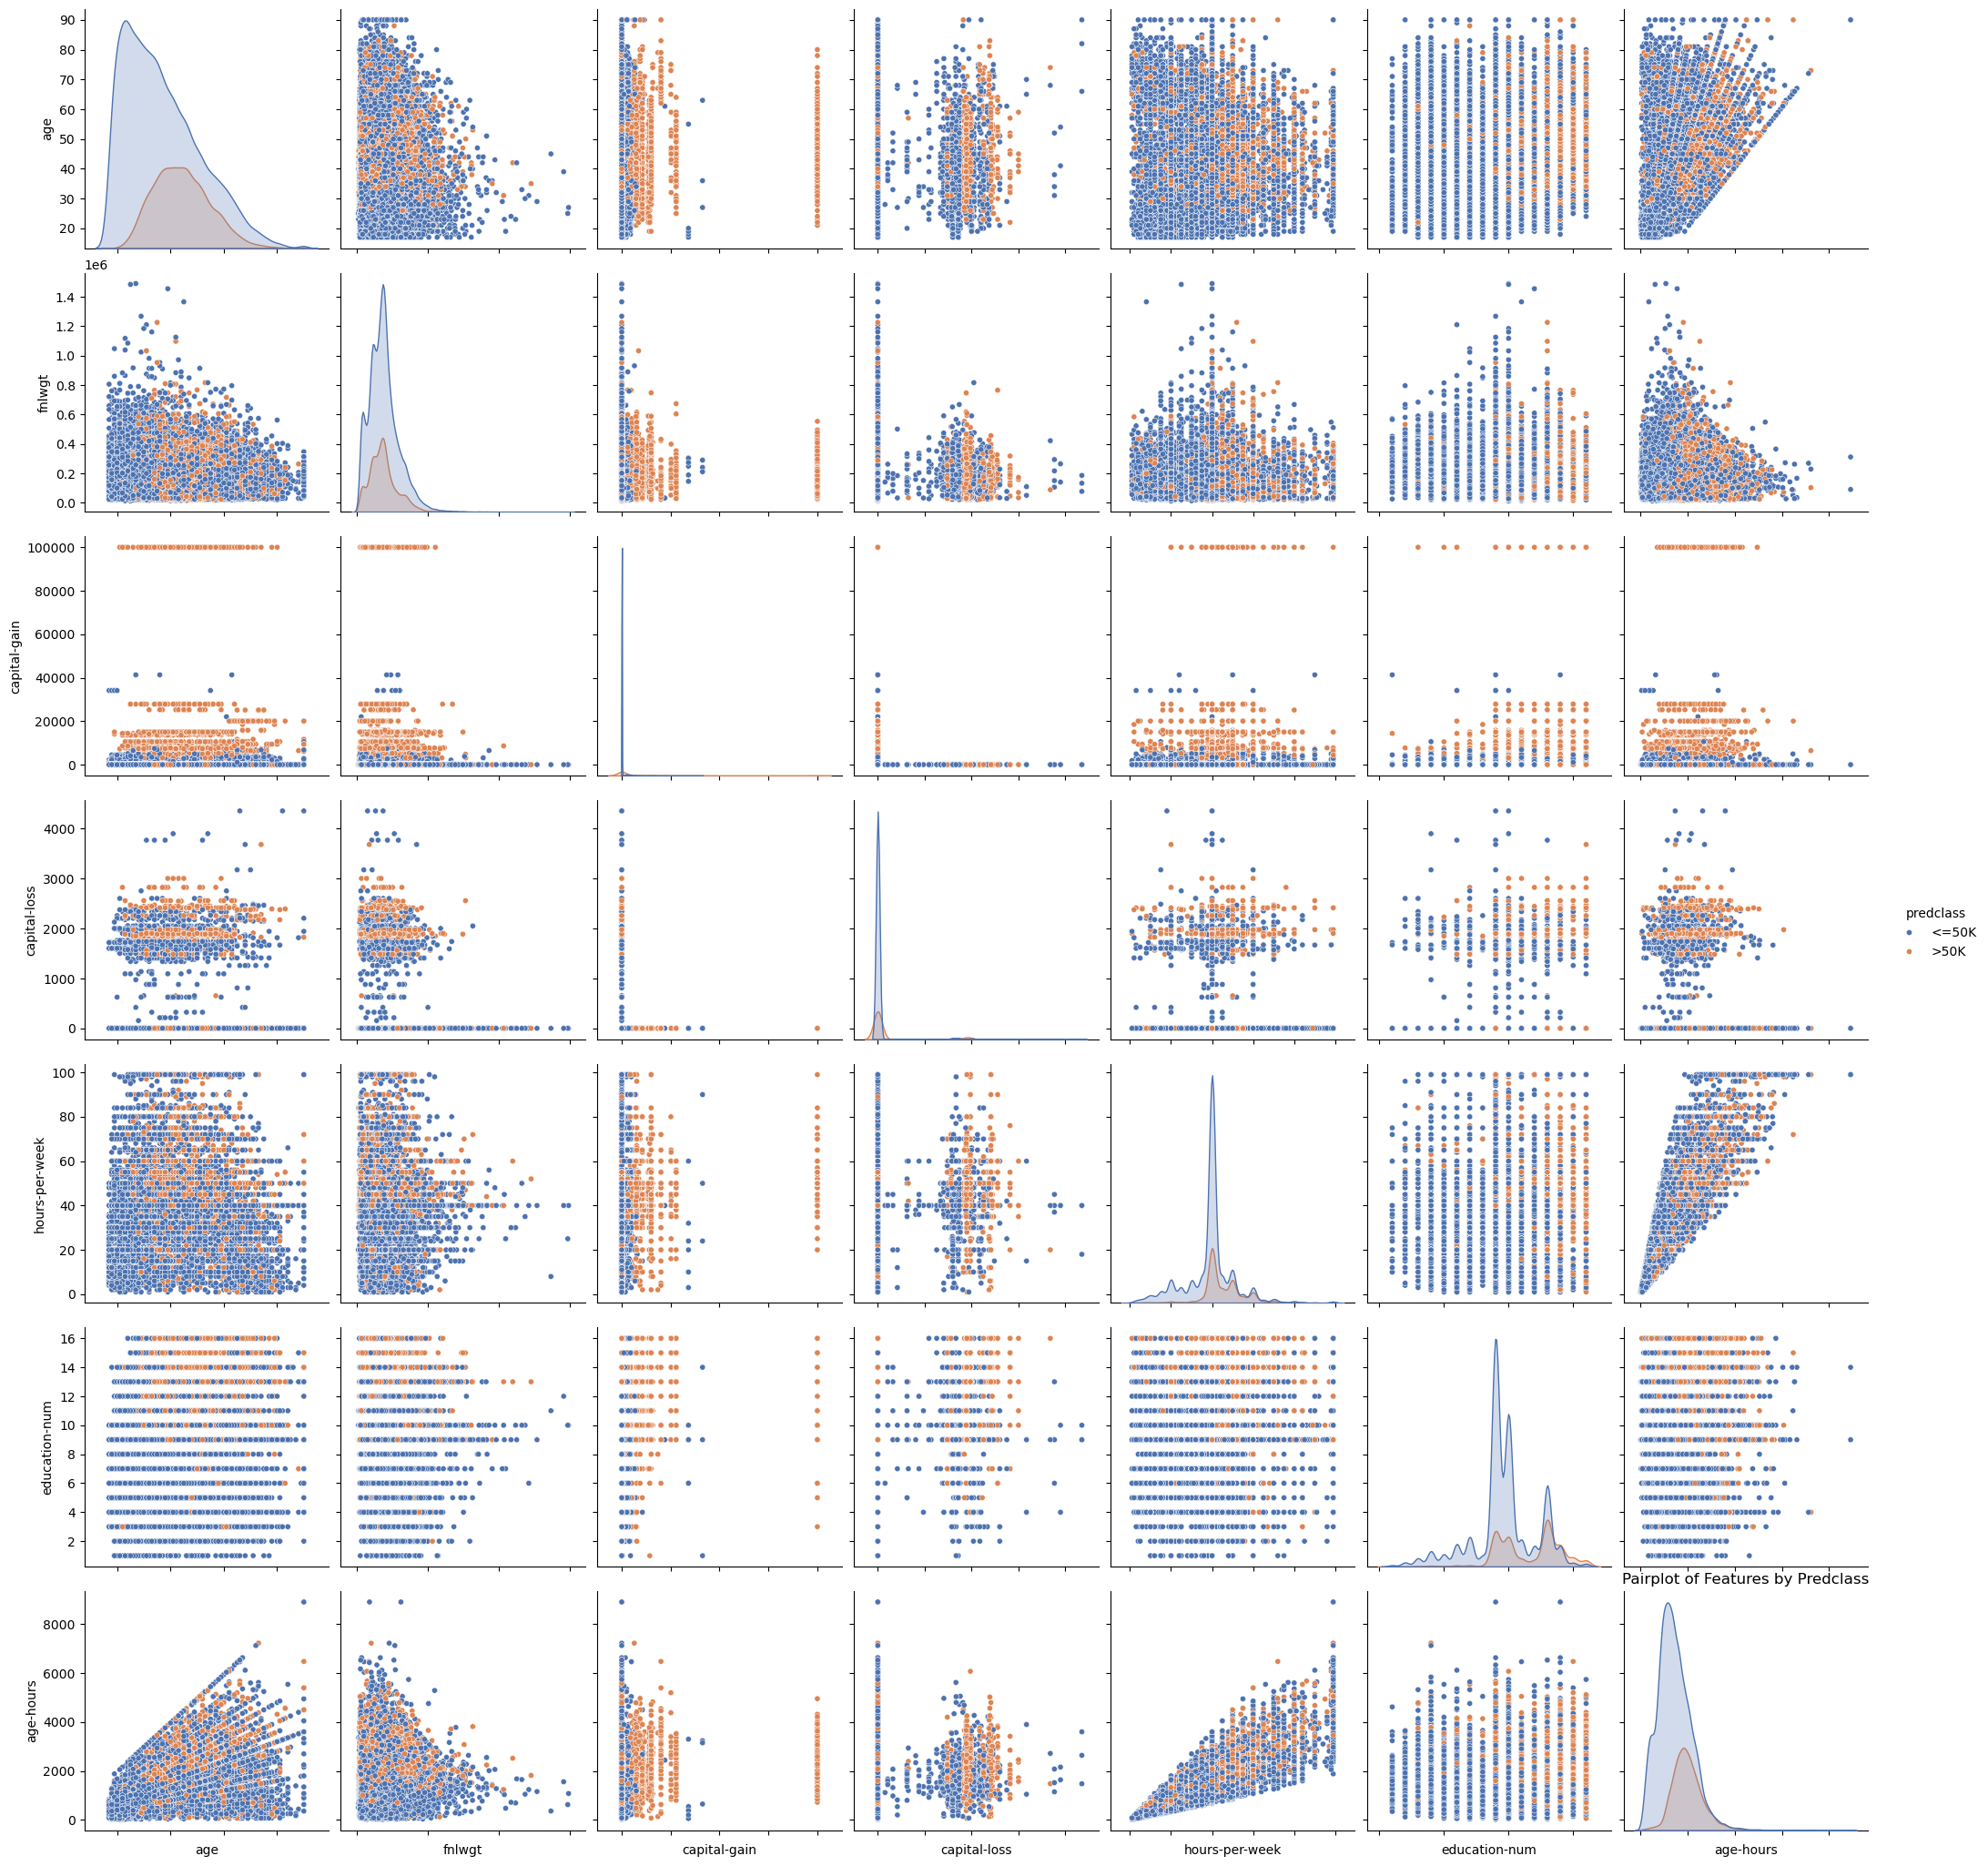

In [11]:
perform_eda(cleaned_df)

In [12]:
X_train, X_test, y_train, y_test, feature_names = prepare_data(cleaned_df)

Dataset URL: https://www.kaggle.com/datasets/wenruliu/adult-income-dataset?resource=download

Attributes and Value Ranges:
age: continuous
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
fnlwgt: continuous
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
education-num: continuous
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
sex: Female, Male
capital-gain: continuous
c


Sample Testing Examples (Before Label Encoding and Scaling):



Sample Training Examples (After Label Encoding and Scaling):



Sample Testing Examples (After Label Encoding and Scaling):


### Step 9: Compare Different ML Models

In [13]:
performance_results, total_execution_time, total_memory_consumed, trained_models = measure_performance(X_train, y_train, X_test, y_test)

Model Training and Testing Progress:   0%|          | 0/7 [00:00<?, ?it/s]

Training and testing Naive Bayes...
Training and testing Linear SVM...


Model Training and Testing Progress:  29%|██▊       | 2/7 [00:30<01:15, 15.16s/it]

Training and testing Radial SVM...


Model Training and Testing Progress:  43%|████▎     | 3/7 [01:07<01:38, 24.52s/it]

Training and testing Logistic Regression...


Model Training and Testing Progress:  57%|█████▋    | 4/7 [01:08<00:46, 15.46s/it]

Training and testing Decision Tree...


Model Training and Testing Progress:  71%|███████▏  | 5/7 [01:08<00:20, 10.37s/it]

Training and testing KNN...


Model Training and Testing Progress:  86%|████████▌ | 6/7 [01:12<00:08,  8.21s/it]

Training and testing Random Forest...


Model Training and Testing Progress: 100%|██████████| 7/7 [01:16<00:00, 11.00s/it]

Total Execution Time: 76.99 seconds
Total Memory Consumed: 164.80 MB


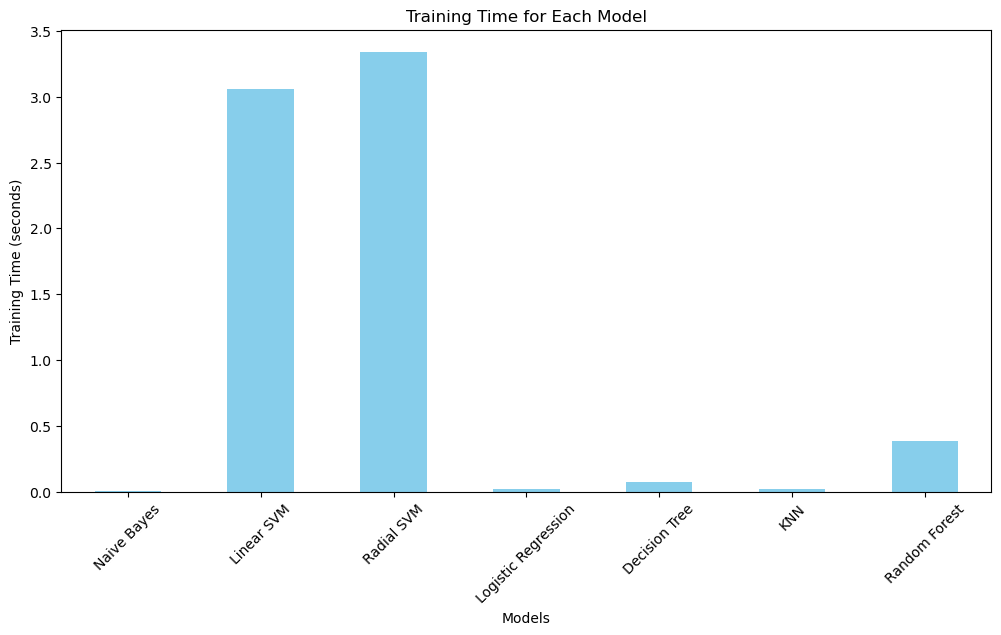

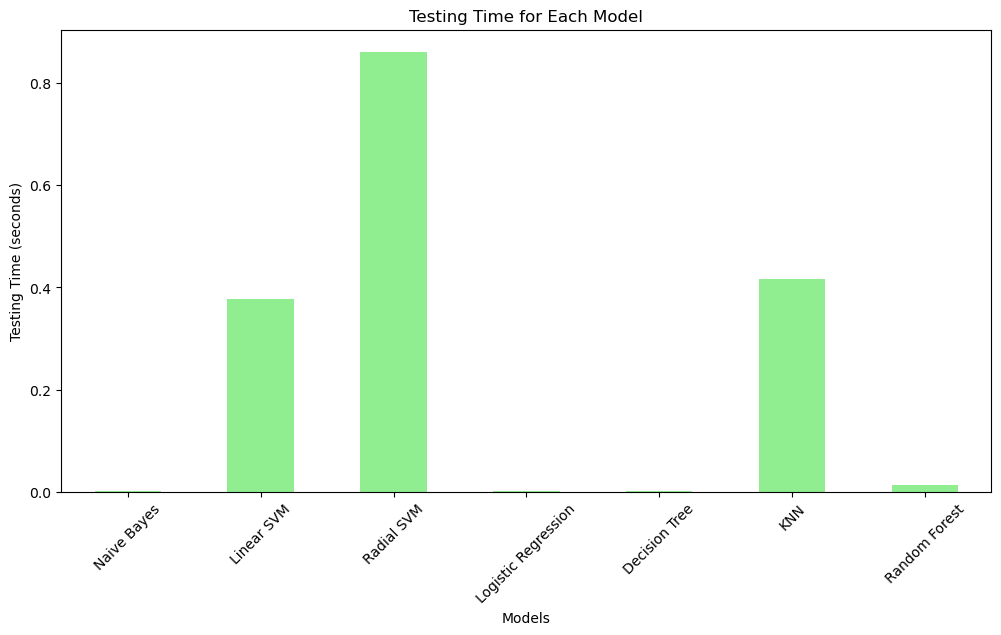

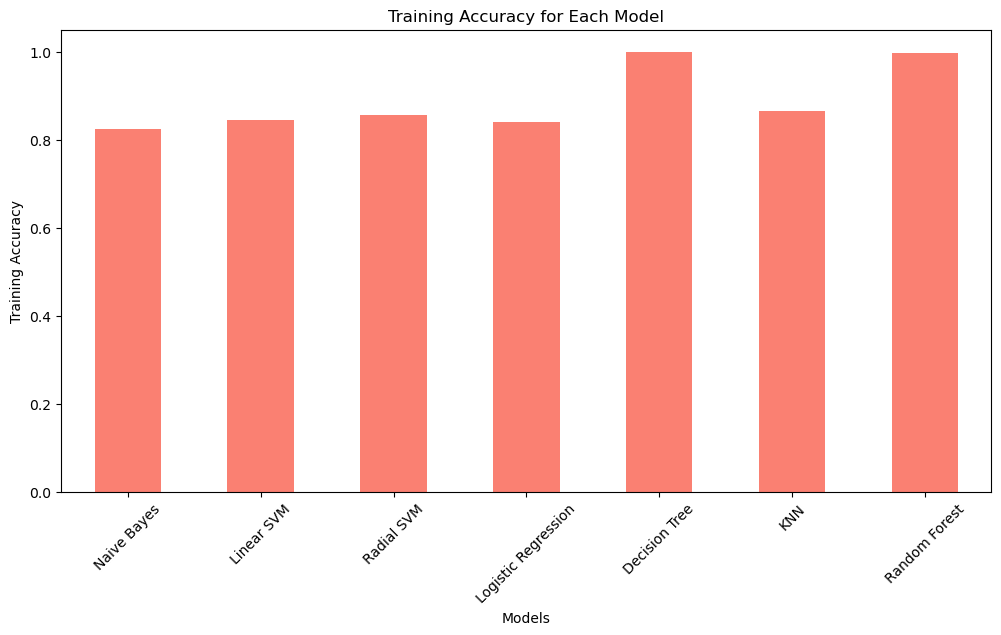

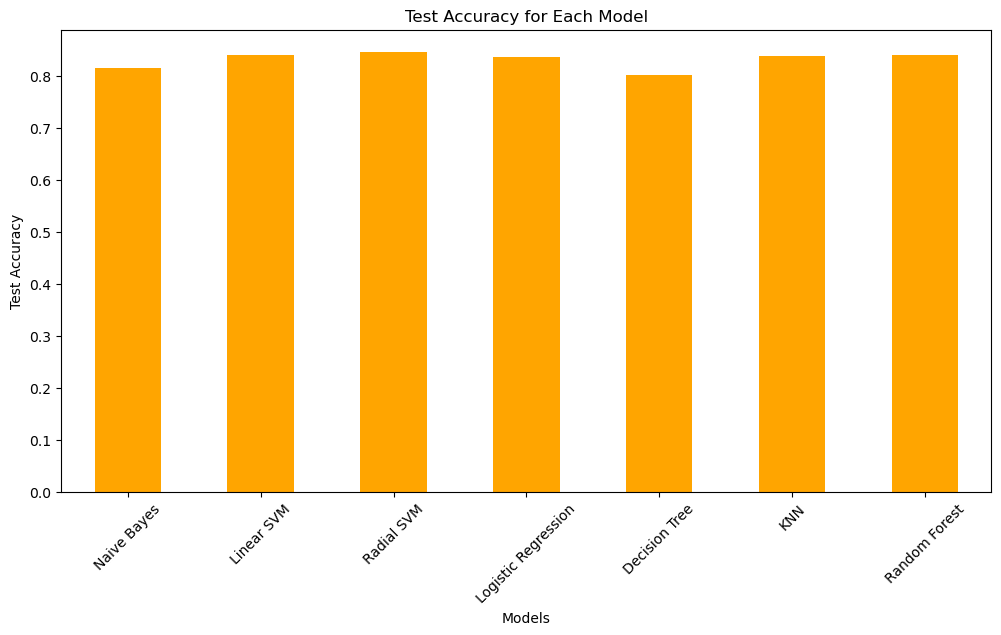

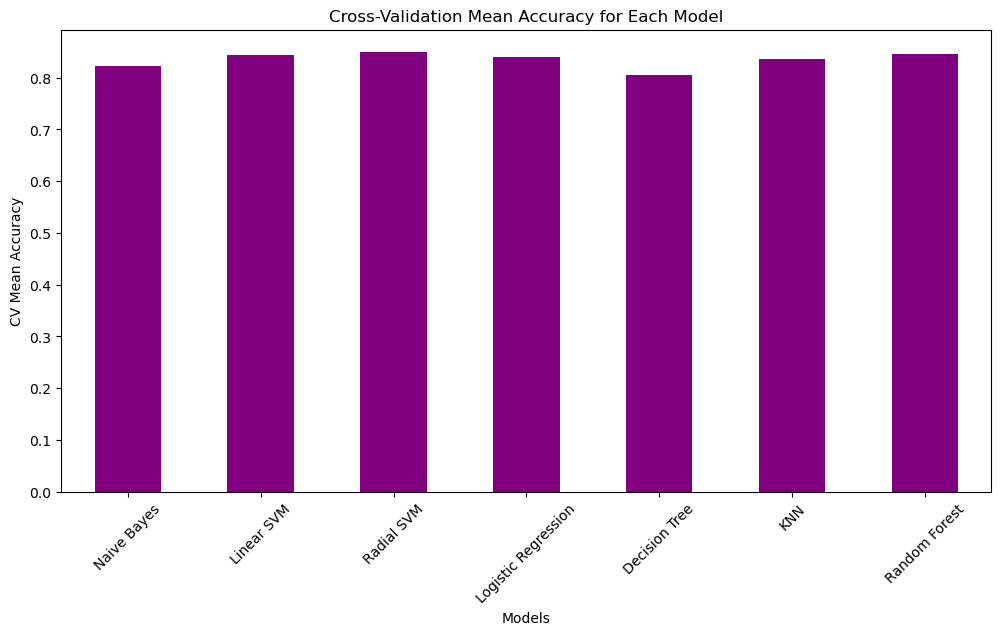

Total Execution Time: 76.99 seconds
Total Memory Consumed: 164.80 MB


In [14]:
compare_ML_models_graphs(performance_results, total_execution_time, total_memory_consumed)

### Step 10: Compare Decision Tree and Random Forests with various configurations

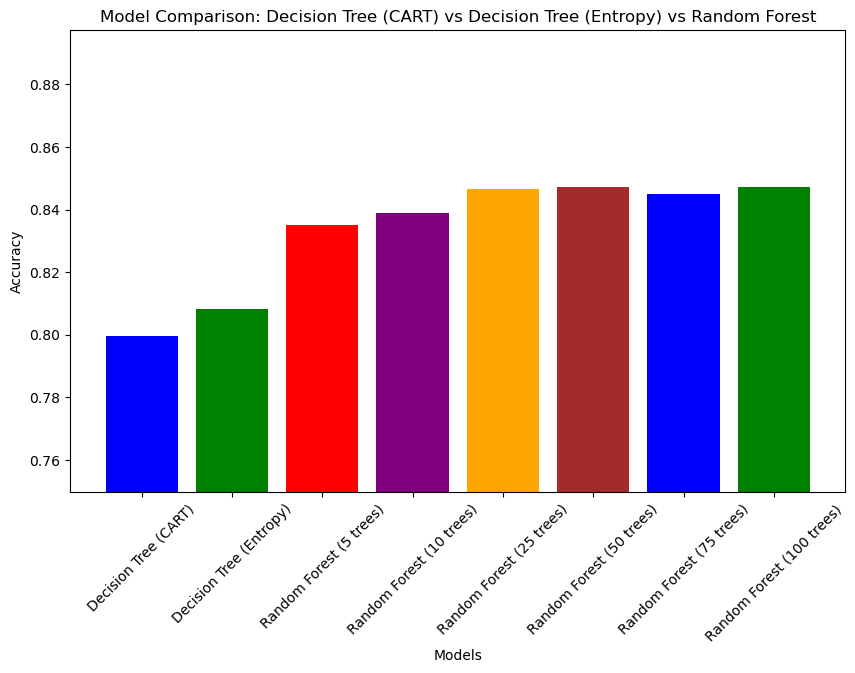

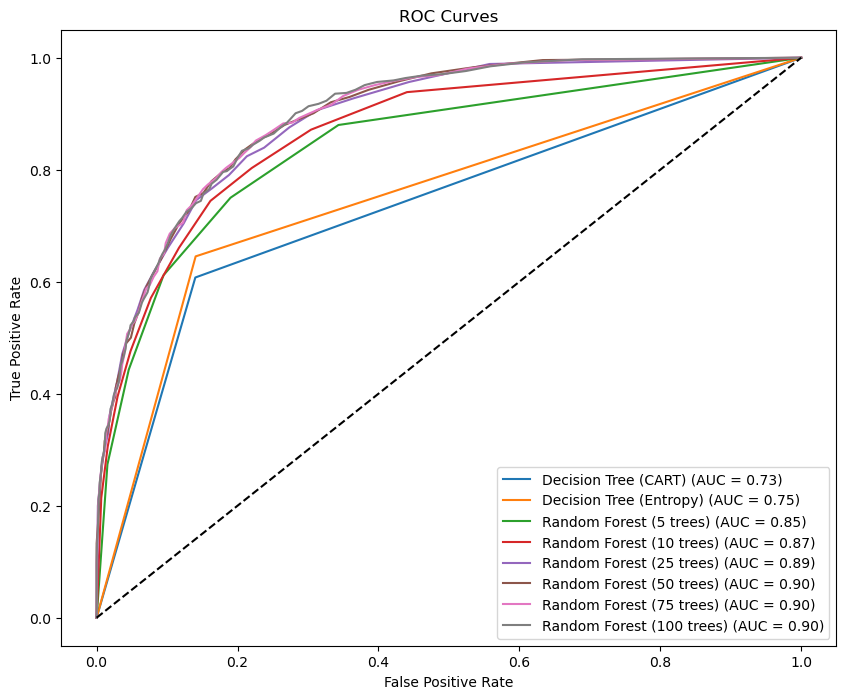


Feature Importance for Decision Tree (CART):
           feature  importance
3   marital-status    0.205479
2           fnlwgt    0.175828
11   education-num    0.135154
12       age-hours    0.114872
8     capital-gain    0.102655

Feature Importance for Decision Tree (Entropy):
           feature  importance
3   marital-status    0.196647
2           fnlwgt    0.180073
12       age-hours    0.124292
11   education-num    0.119022
8     capital-gain    0.103060

Feature Importance for Random Forest (5 trees):
          feature  importance
2          fnlwgt    0.141450
12      age-hours    0.128455
8    capital-gain    0.123420
0             age    0.117784
11  education-num    0.106569

Feature Importance for Random Forest (10 trees):
          feature  importance
2          fnlwgt    0.136500
8    capital-gain    0.129848
12      age-hours    0.127348
0             age    0.109788
11  education-num    0.109370

Feature Importance for Random Forest (25 trees):
          feature  impor

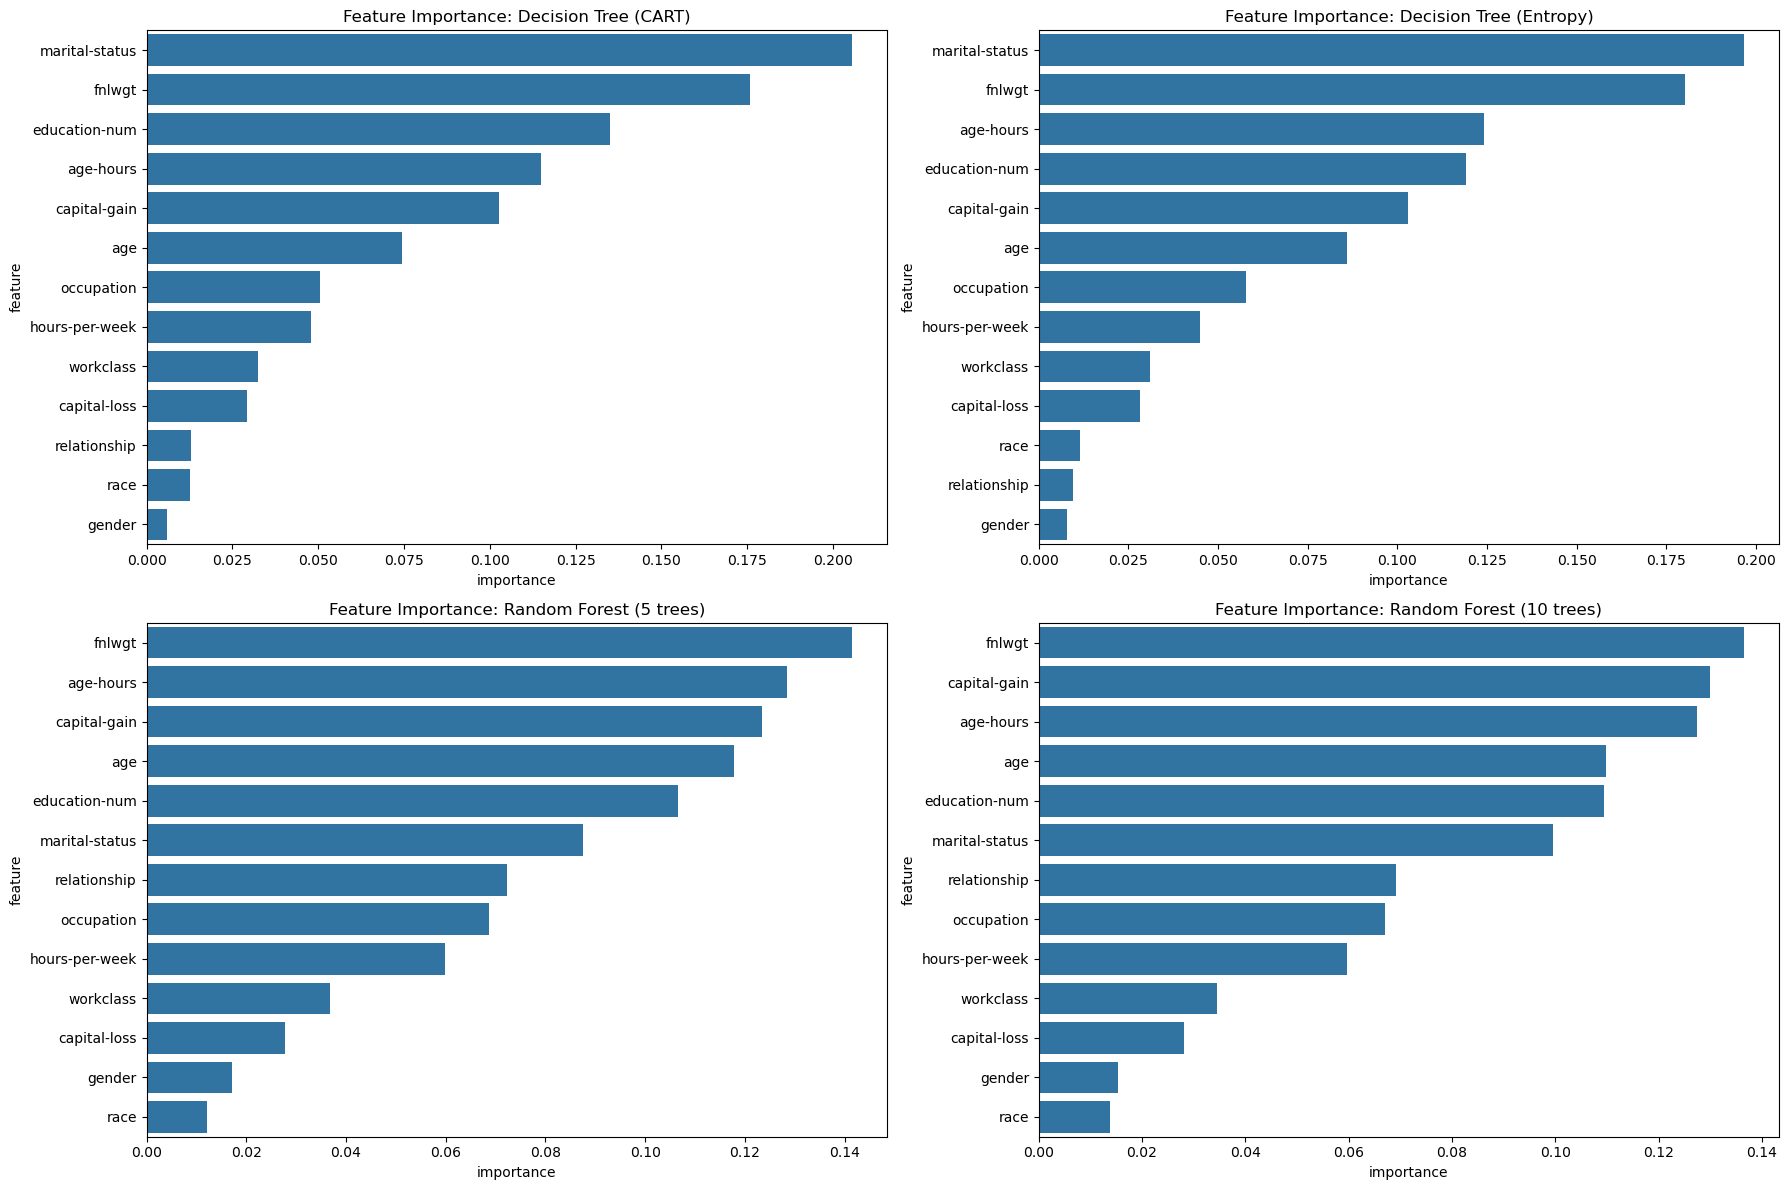

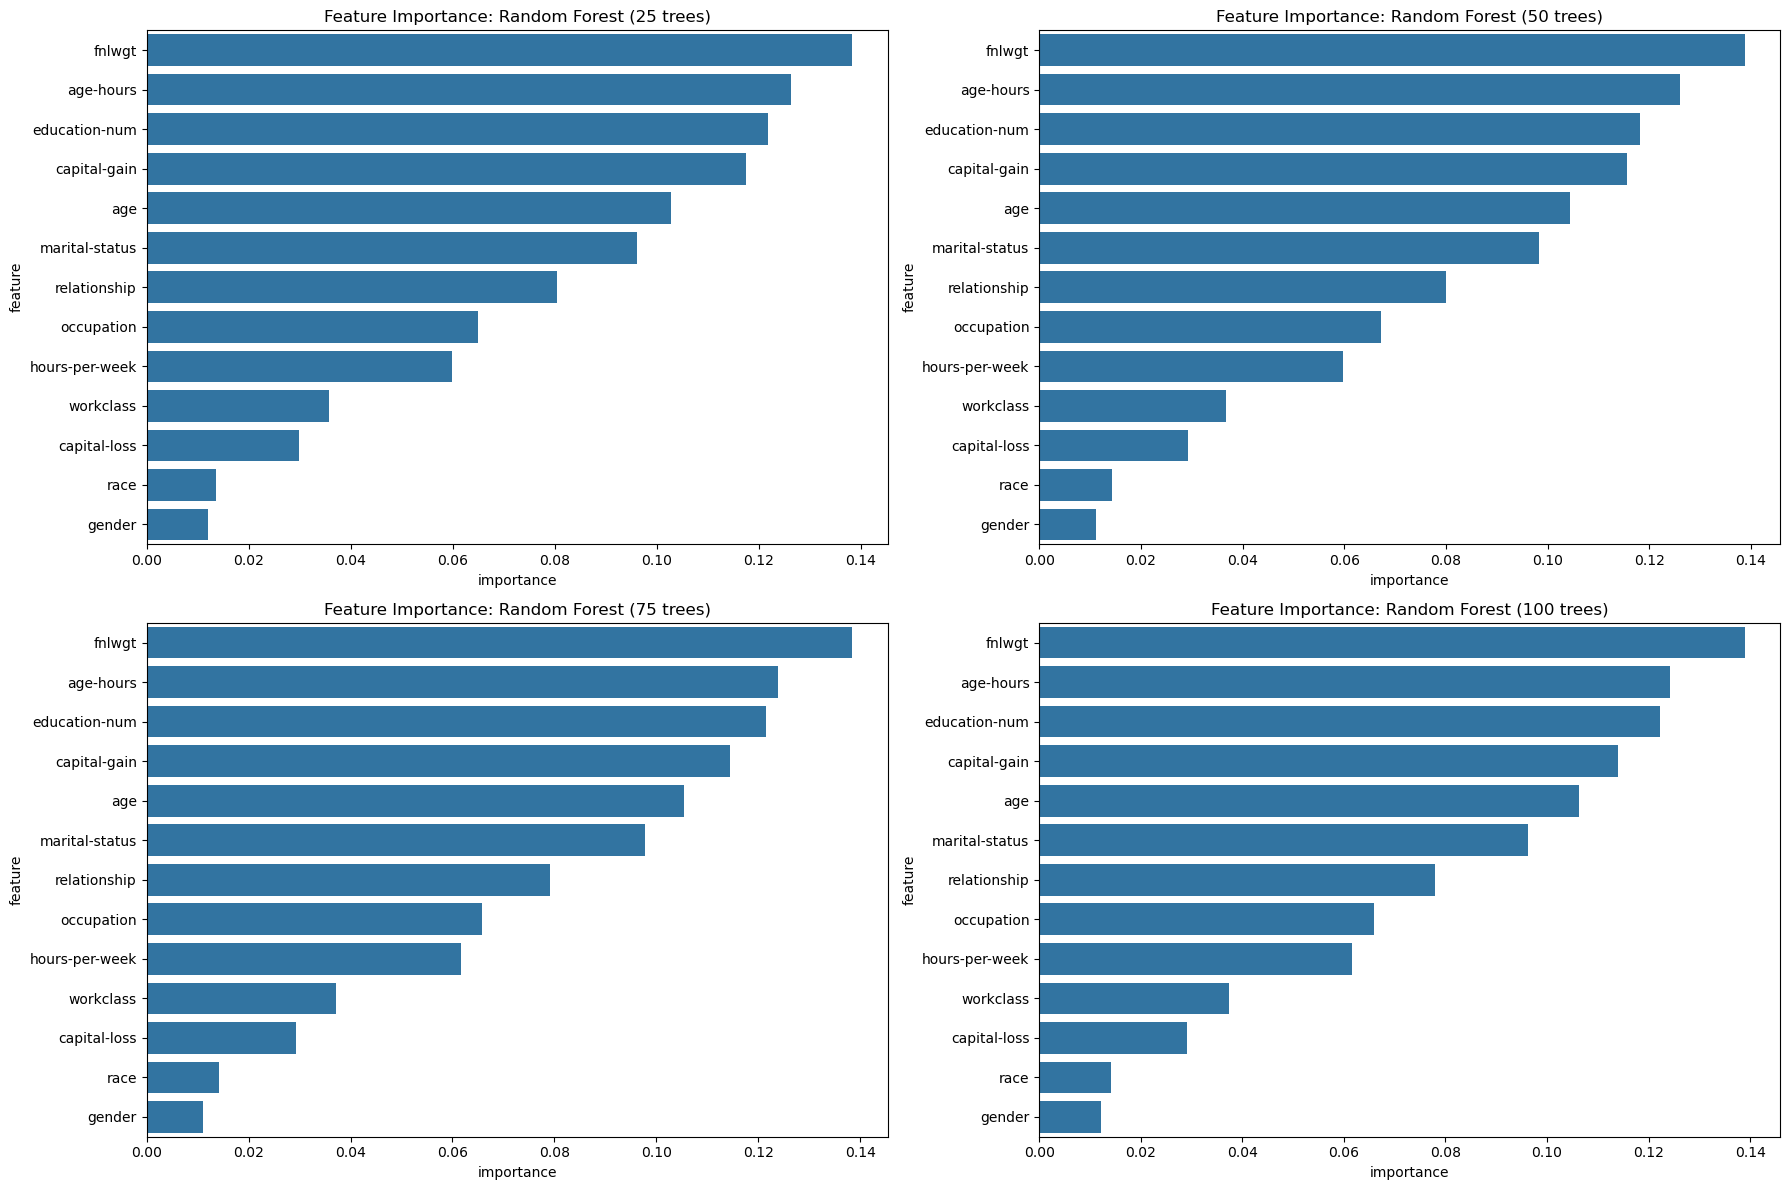


Hyper-parameters for Decision Tree (CART):
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 100, 'splitter': 'best'}

Hyper-parameters for Decision Tree (Entropy):
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 100, 'splitter': 'best'}

Hyper-parameters for Random Forest (5 trees):
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight

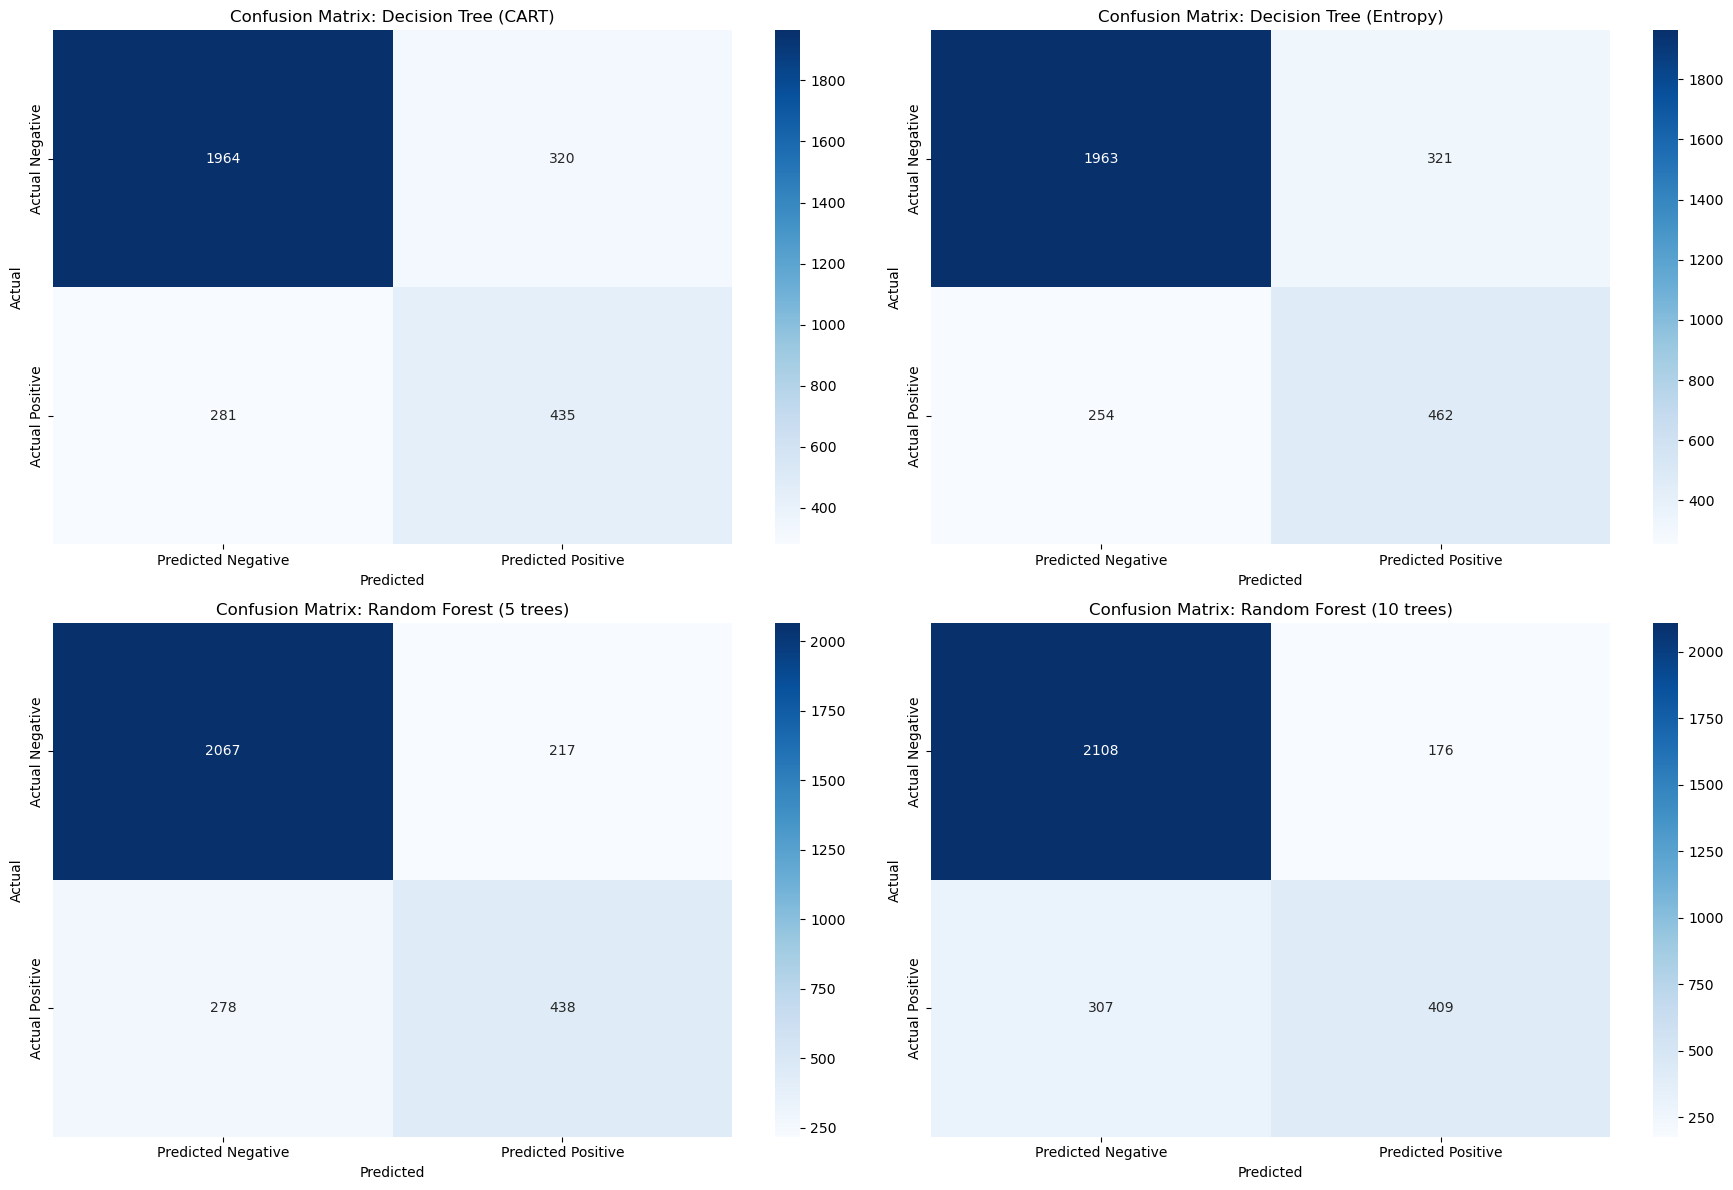

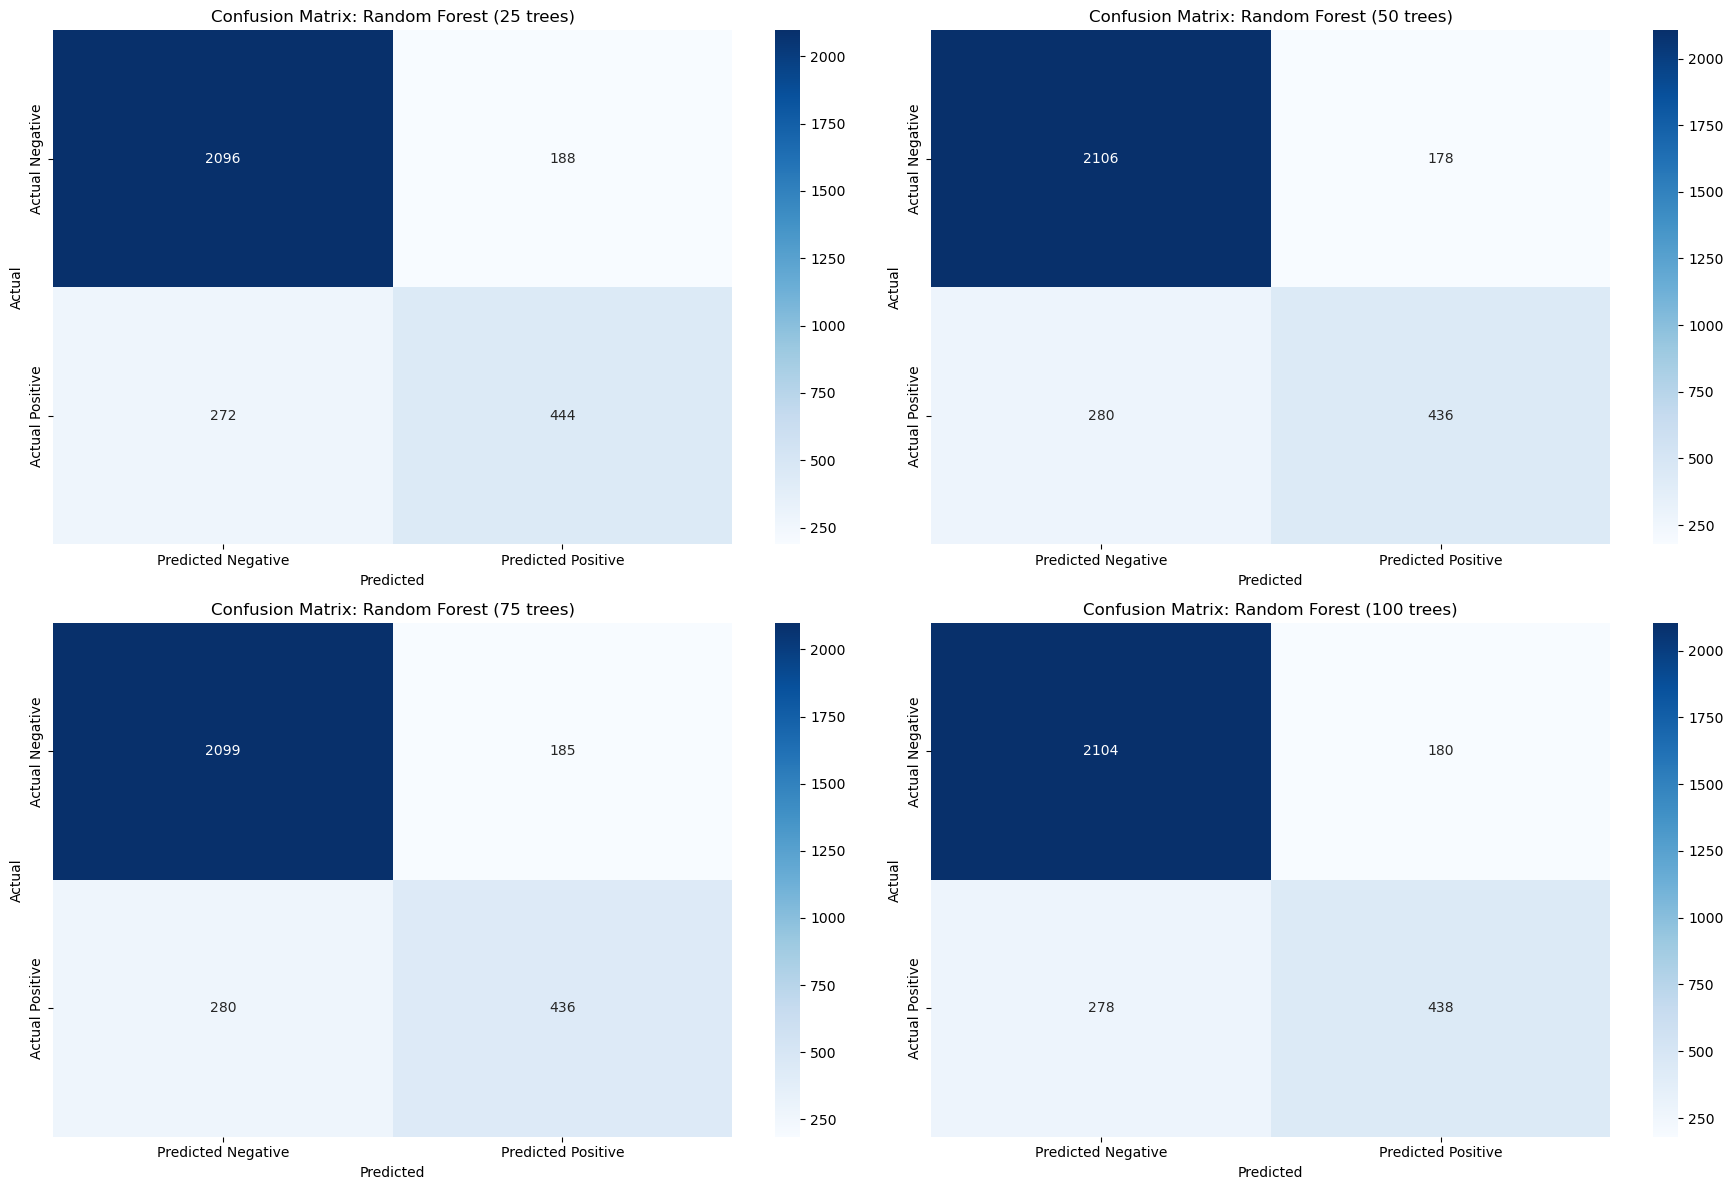


Classification Reports:

Classification Report for Decision Tree (CART):


precision    recall  f1-score      support
0              0.874833  0.859895  0.867300  2284.000000
1              0.576159  0.607542  0.591434   716.000000
accuracy       0.799667  0.799667  0.799667     0.799667
macro avg      0.725496  0.733718  0.729367  3000.000000
weighted avg   0.803549  0.799667  0.801460  3000.000000


Classification Report for Decision Tree (Entropy):


precision    recall  f1-score      support
0              0.885431  0.859457  0.872251  2284.000000
1              0.590038  0.645251  0.616411   716.000000
accuracy       0.808333  0.808333  0.808333     0.808333
macro avg      0.737735  0.752354  0.744331  3000.000000
weighted avg   0.814930  0.808333  0.811190  3000.000000


Classification Report for Random Forest (5 trees):


precision    recall  f1-score   support
0              0.881450  0.904991  0.893065  2284.000
1              0.668702  0.611732  0.638950   716.000
accuracy       0.835000  0.835000  0.835000     0.835
macro avg      0.775076  0.758362  0.766008  3000.000
weighted avg   0.830674  0.835000  0.832416  3000.000


Classification Report for Random Forest (10 trees):


precision    recall  f1-score   support
0              0.872878  0.922942  0.897212  2284.000
1              0.699145  0.571229  0.628747   716.000
accuracy       0.839000  0.839000  0.839000     0.839
macro avg      0.786012  0.747086  0.762980  3000.000
weighted avg   0.831414  0.839000  0.833139  3000.000


Classification Report for Random Forest (25 trees):


precision    recall  f1-score      support
0              0.885135  0.917688  0.901118  2284.000000
1              0.702532  0.620112  0.658754   716.000000
accuracy       0.846667  0.846667  0.846667     0.846667
macro avg      0.793833  0.768900  0.779936  3000.000000
weighted avg   0.841554  0.846667  0.843274  3000.000000


Classification Report for Random Forest (50 trees):


precision    recall  f1-score      support
0              0.882649  0.922067  0.901927  2284.000000
1              0.710098  0.608939  0.655639   716.000000
accuracy       0.847333  0.847333  0.847333     0.847333
macro avg      0.796373  0.765503  0.778783  3000.000000
weighted avg   0.841467  0.847333  0.843146  3000.000000


Classification Report for Random Forest (75 trees):


precision    recall  f1-score   support
0              0.882303  0.919002  0.900279  2284.000
1              0.702093  0.608939  0.652206   716.000
accuracy       0.845000  0.845000  0.845000     0.845
macro avg      0.792198  0.763970  0.776243  3000.000
weighted avg   0.839293  0.845000  0.841072  3000.000


Classification Report for Random Forest (100 trees):


precision    recall  f1-score      support
0              0.883291  0.921191  0.901843  2284.000000
1              0.708738  0.611732  0.656672   716.000000
accuracy       0.847333  0.847333  0.847333     0.847333
macro avg      0.796015  0.766461  0.779257  3000.000000
weighted avg   0.841631  0.847333  0.843329  3000.000000


Training and Testing Times:


Model  Training Time (s)  Testing Time (s)
0       Decision Tree (CART)           0.075340          0.000700
1    Decision Tree (Entropy)           0.088903          0.000753
2    Random Forest (5 trees)           0.079247          0.002894
3   Random Forest (10 trees)           0.161351          0.005198
4   Random Forest (25 trees)           0.393364          0.012380
5   Random Forest (50 trees)           0.771246          0.024158
6   Random Forest (75 trees)           1.162814          0.036546
7  Random Forest (100 trees)           1.553201          0.049166

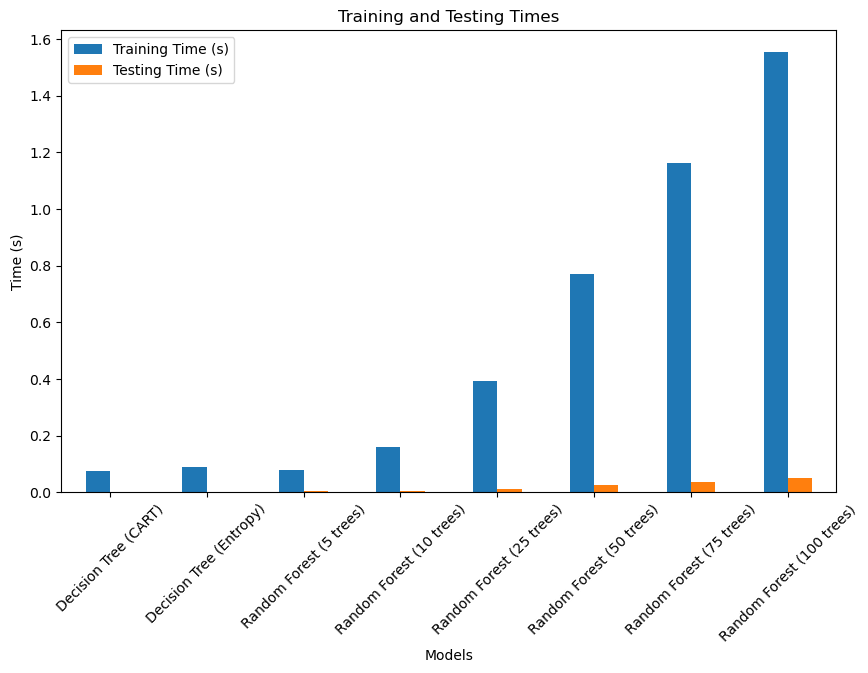


Top and Bottom Trees for Random Forest (5 trees):


Top 10 Trees Index  Top 10 Trees Accuracy  Bottom 10 Trees Index  \
0                   3               0.801333                      3   
1                   4               0.801333                      4   
2                   1               0.797667                      1   
3                   0               0.797000                      0   
4                   2               0.790667                      2   

   Bottom 10 Trees Accuracy  First 10 Trees Index  First 10 Trees Accuracy  \
0                  0.801333                     0                 0.797000   
1                  0.801333                     1                 0.797667   
2                  0.797667                     2                 0.790667   
3                  0.797000                     3                 0.801333   
4                  0.790667                     4                 0.801333   

   Last 10 Trees Index  Last 10 Trees Accuracy  
0                    0                0.797000  
1                    1                0.797667  
2                    2                0.790667  
3                    3                0.801333  
4                    4                0.801333


Top and Bottom Trees for Random Forest (10 trees):


Top 10 Trees Index  Top 10 Trees Accuracy  Bottom 10 Trees Index  \
0                   5               0.802000                      5   
1                   3               0.801333                      3   
2                   4               0.801333                      4   
3                   1               0.797667                      1   
4                   0               0.797000                      0   
5                   8               0.797000                      8   
6                   6               0.796667                      6   
7                   7               0.795667                      7   
8                   2               0.790667                      2   
9                   9               0.779667                      9   

   Bottom 10 Trees Accuracy  First 10 Trees Index  First 10 Trees Accuracy  \
0                  0.802000                     0                 0.797000   
1                  0.801333                     1                 0.797667   
2                  0.801333                     2                 0.790667   
3                  0.797667                     3                 0.801333   
4                  0.797000                     4                 0.801333   
5                  0.797000                     5                 0.802000   
6                  0.796667                     6                 0.796667   
7                  0.795667                     7                 0.795667   
8                  0.790667                     8                 0.797000   
9                  0.779667                     9                 0.779667   

   Last 10 Trees Index  Last 10 Trees Accuracy  
0                    0                0.797000  
1                    1                0.797667  
2                    2                0.790667  
3                    3                0.801333  
4                    4                0.801333  
5                    5                0.802000  
6                    6                0.796667  
7                    7                0.795667  
8                    8                0.797000  
9                    9                0.779667


Top and Bottom Trees for Random Forest (25 trees):


Top 10 Trees Index  Top 10 Trees Accuracy  Bottom 10 Trees Index  \
0                  16               0.815000                      8   
1                  10               0.809333                      6   
2                  21               0.806667                      7   
3                  20               0.804333                     15   
4                  19               0.803333                     24   
5                   5               0.802000                     17   
6                  23               0.802000                      2   
7                  12               0.801667                     13   
8                   3               0.801333                     14   
9                   4               0.801333                      9   

   Bottom 10 Trees Accuracy  First 10 Trees Index  First 10 Trees Accuracy  \
0                  0.797000                     0                 0.797000   
1                  0.796667                     1                 0.797667   
2                  0.795667                     2                 0.790667   
3                  0.795667                     3                 0.801333   
4                  0.794333                     4                 0.801333   
5                  0.793333                     5                 0.802000   
6                  0.790667                     6                 0.796667   
7                  0.790000                     7                 0.795667   
8                  0.787000                     8                 0.797000   
9                  0.779667                     9                 0.779667   

   Last 10 Trees Index  Last 10 Trees Accuracy  
0                   15                0.795667  
1                   16                0.815000  
2                   17                0.793333  
3                   18                0.800333  
4                   19                0.803333  
5                   20                0.804333  
6                   21                0.806667  
7                   22                0.801333  
8                   23                0.802000  
9                   24                0.794333


Top and Bottom Trees for Random Forest (50 trees):


Top 10 Trees Index  Top 10 Trees Accuracy  Bottom 10 Trees Index  \
0                  16               0.815000                     37   
1                  38               0.810333                     46   
2                  10               0.809333                      2   
3                  21               0.806667                     47   
4                  43               0.805333                     13   
5                  20               0.804333                     14   
6                  29               0.804000                     35   
7                  19               0.803333                     27   
8                   5               0.802000                     31   
9                  23               0.802000                      9   

   Bottom 10 Trees Accuracy  First 10 Trees Index  First 10 Trees Accuracy  \
0                  0.791000                     0                 0.797000   
1                  0.791000                     1                 0.797667   
2                  0.790667                     2                 0.790667   
3                  0.790333                     3                 0.801333   
4                  0.790000                     4                 0.801333   
5                  0.787000                     5                 0.802000   
6                  0.787000                     6                 0.796667   
7                  0.786667                     7                 0.795667   
8                  0.780667                     8                 0.797000   
9                  0.779667                     9                 0.779667   

   Last 10 Trees Index  Last 10 Trees Accuracy  
0                   40                0.798000  
1                   41                0.796333  
2                   42                0.791333  
3                   43                0.805333  
4                   44                0.799000  
5                   45                0.797333  
6                   46                0.791000  
7                   47                0.790333  
8                   48                0.799667  
9                   49                0.800333


Top and Bottom Trees for Random Forest (75 trees):


Top 10 Trees Index  Top 10 Trees Accuracy  Bottom 10 Trees Index  \
0                  16               0.815000                     65   
1                  38               0.810333                     14   
2                  10               0.809333                     35   
3                  51               0.807000                     27   
4                  21               0.806667                     50   
5                  62               0.806667                     74   
6                  43               0.805333                     63   
7                  20               0.804333                     31   
8                  29               0.804000                      9   
9                  68               0.803667                     58   

   Bottom 10 Trees Accuracy  First 10 Trees Index  First 10 Trees Accuracy  \
0                  0.790000                     0                 0.797000   
1                  0.787000                     1                 0.797667   
2                  0.787000                     2                 0.790667   
3                  0.786667                     3                 0.801333   
4                  0.786667                     4                 0.801333   
5                  0.785667                     5                 0.802000   
6                  0.784000                     6                 0.796667   
7                  0.780667                     7                 0.795667   
8                  0.779667                     8                 0.797000   
9                  0.778000                     9                 0.779667   

   Last 10 Trees Index  Last 10 Trees Accuracy  
0                   65                0.790000  
1                   66                0.794000  
2                   67                0.801333  
3                   68                0.803667  
4                   69                0.793000  
5                   70                0.803667  
6                   71                0.803000  
7                   72                0.794667  
8                   73                0.797000  
9                   74                0.785667


Top and Bottom Trees for Random Forest (100 trees):


Top 10 Trees Index  Top 10 Trees Accuracy  Bottom 10 Trees Index  \
0                  16               0.815000                     50   
1                  38               0.810333                     82   
2                  10               0.809333                     74   
3                  97               0.808333                     96   
4                  51               0.807000                     63   
5                  21               0.806667                     78   
6                  62               0.806667                     83   
7                  43               0.805333                     31   
8                  79               0.805333                      9   
9                  75               0.805000                     58   

   Bottom 10 Trees Accuracy  First 10 Trees Index  First 10 Trees Accuracy  \
0                  0.786667                     0                 0.797000   
1                  0.786000                     1                 0.797667   
2                  0.785667                     2                 0.790667   
3                  0.785333                     3                 0.801333   
4                  0.784000                     4                 0.801333   
5                  0.783667                     5                 0.802000   
6                  0.781000                     6                 0.796667   
7                  0.780667                     7                 0.795667   
8                  0.779667                     8                 0.797000   
9                  0.778000                     9                 0.779667   

   Last 10 Trees Index  Last 10 Trees Accuracy  
0                   90                0.796667  
1                   91                0.800000  
2                   92                0.795667  
3                   93                0.792333  
4                   94                0.801333  
5                   95                0.795667  
6                   96                0.785333  
7                   97                0.808333  
8                   98                0.792333  
9                   99                0.797333

In [15]:
results = compare_decision_tree_vs_random_forest(X_train, y_train, X_test, y_test, feature_names)

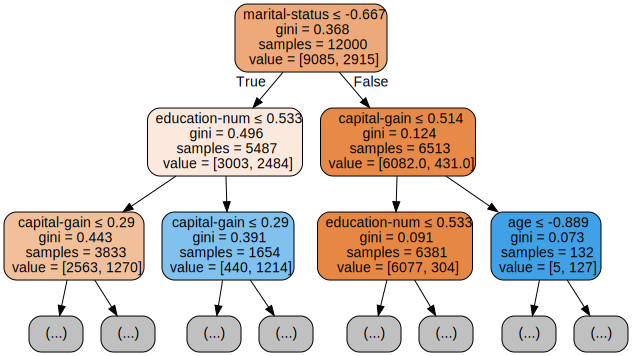

In [16]:
display(results["tree_images"]["Decision Tree (CART)"])

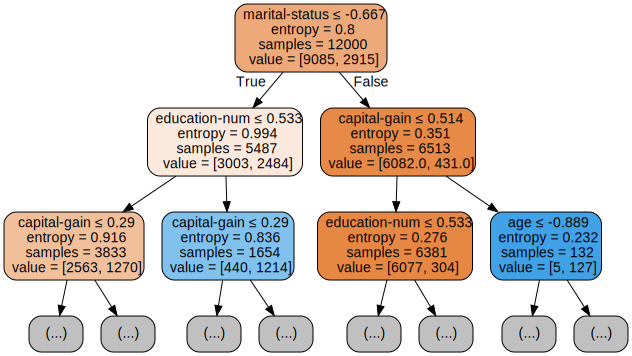

In [17]:
display(results["tree_images"]["Decision Tree (Entropy)"])

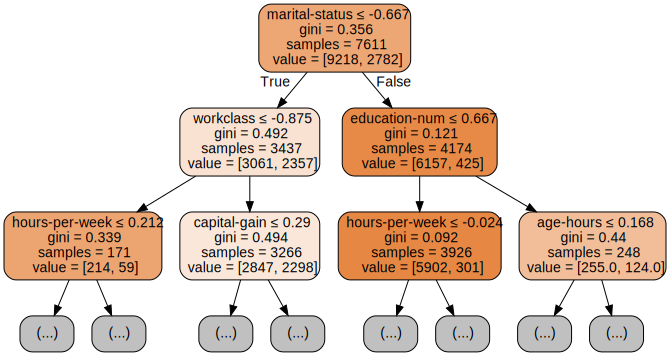

In [18]:
display(results["tree_images"]["Random Forest (5 trees)"])

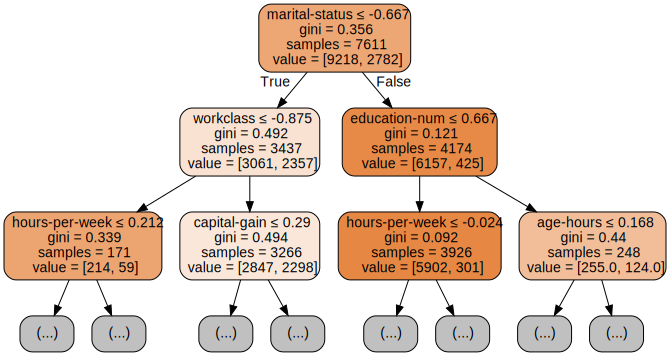

In [19]:
display(results["tree_images"]["Random Forest (10 trees)"])

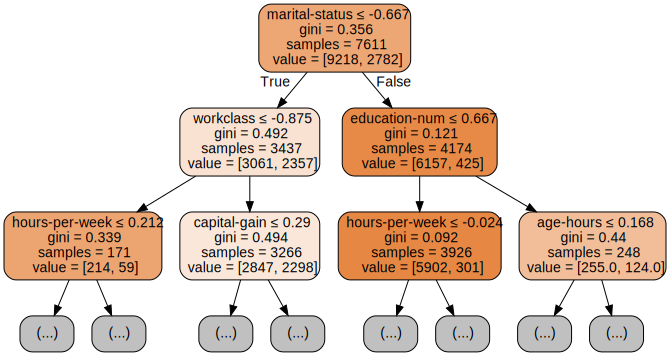

In [20]:
display(results["tree_images"]["Random Forest (25 trees)"])

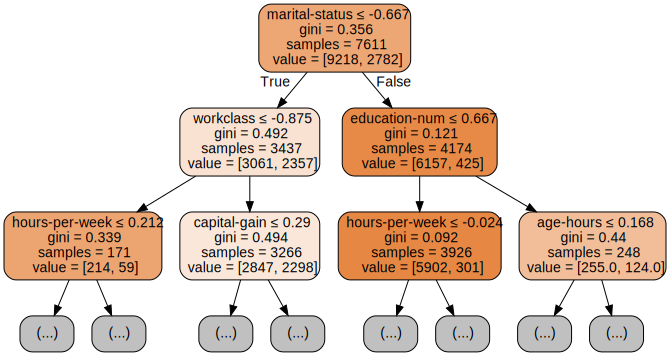

In [21]:
display(results["tree_images"]["Random Forest (50 trees)"])

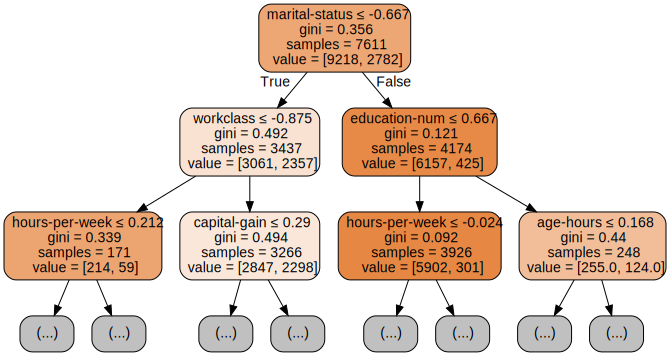

In [22]:
display(results["tree_images"]["Random Forest (75 trees)"])

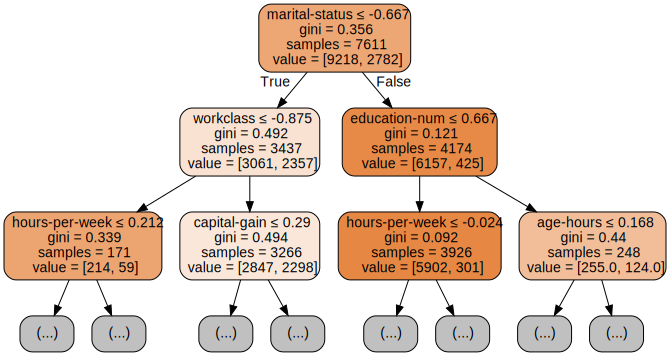

In [23]:
display(results["tree_images"]["Random Forest (100 trees)"])